In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
mnist_train_y = hd5_open('../../DHC/scratch_AKS/data/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../../DHC/scratch_AKS/data/mnist_test_y.h5','main/data')

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

def cm_eval(y_pred, y_true,n_classes):
    cm = np.zeros((n_classes,n_classes))
    for indx in range(y_pred.shape[0]):
        cm[y_true[indx],y_pred[indx]] += 1
    return cm.astype(int)

In [4]:
mnist_DHC_out_train_L4s = hd5_open('../from_cannon/2021_03_09/mnist_DHC_train_eq_L4_s.h5','main/data')
mnist_DHC_out_test_L4s = hd5_open('../from_cannon/2021_03_09/mnist_DHC_test_eq_L4_s.h5','main/data')

In [5]:
mnist_DHC_out_train_L4s_angles = hd5_open('../from_cannon/2021_03_09/mnist_DHC_train_eq_L4_s.h5','main/angles')
mnist_DHC_out_test_L4s_angles = hd5_open('../from_cannon/2021_03_09/mnist_DHC_test_eq_L4_s.h5','main/angles')

In [6]:
NtestAngle = mnist_DHC_out_test_L4s_angles.shape[0]
NtrainAngle = mnist_DHC_out_train_L4s_angles.shape[0]

angle_test = np.tile(mnist_DHC_out_test_L4s_angles,10000)
angle_test_class = np.repeat(mnist_test_y,NtestAngle)

angle_train = np.tile(mnist_DHC_out_train_L4s_angles,60000)
angle_train_class = np.repeat(mnist_train_y,NtrainAngle)

lb = LabelBinarizer()
train_y_onehot = lb.fit_transform(angle_train_class)

lb = LabelBinarizer()
test_y_onehot = lb.fit_transform(angle_test_class)

In [7]:
NTrainSubset = 12
idx = np.round(np.linspace(0, NtrainAngle - 1, 12)).astype(int)
sc = StandardScaler()
tr_slice = np.logical_and(np.isin(angle_train,mnist_DHC_out_train_L4s_angles[idx]),np.isin(angle_train_class,2))
tst_slice = np.isin(angle_test_class,2)

X_trx = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
Y_trx = np.array([
    np.cos(2*np.mod(angle_train[tr_slice],np.pi))
]).T

X_testx = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
Y_testx = np.array([
    np.cos(2*np.mod(angle_test[tst_slice],np.pi))
]).T

reg = LinearRegression().fit(X_trx, Y_trx)
y_pred_testx = reg.predict(X_testx)
y_pred_trainx = reg.predict(X_trx)

train_lossl2x = np.mean(np.square(y_pred_trainx-Y_trx))
test_lossl2x = np.mean(np.square(y_pred_testx-Y_testx))

In [8]:
NTrainSubset = 12
idx = np.round(np.linspace(0, NtrainAngle - 1, 12)).astype(int)
sc = StandardScaler()
tr_slice = np.logical_and(np.isin(angle_train,mnist_DHC_out_train_L4s_angles[idx]),np.isin(angle_train_class,2))
tst_slice = np.isin(angle_test_class,2)

X_try = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
Y_try = np.array([
    np.sin(2*np.mod(angle_train[tr_slice],np.pi)),
]).T

X_testy = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
Y_testy = np.array([
    np.sin(2*np.mod(angle_test[tst_slice],np.pi))
]).T

reg = LinearRegression().fit(X_try, Y_try)
y_pred_testy = reg.predict(X_testy)
y_pred_trainy = reg.predict(X_try)

train_lossl2y = np.mean(np.square(y_pred_trainy-Y_try))
test_lossl2y = np.mean(np.square(y_pred_testy-Y_testy))

In [15]:
y_pred_testx.shape,y_pred_testy.shape

((49536, 1), (49536, 1))

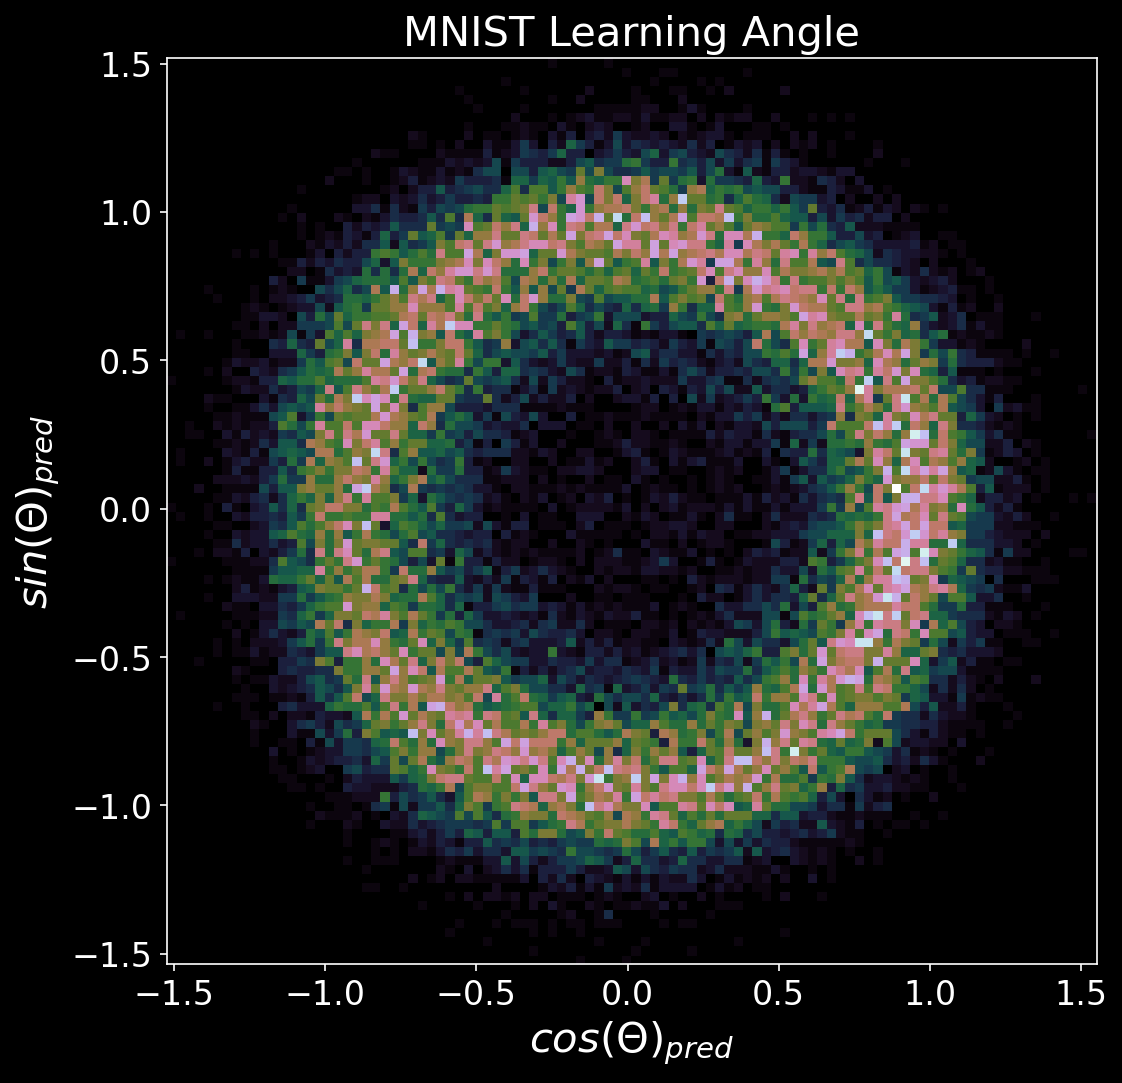

In [18]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
#plt.scatter(Y_test,np.square(y_pred_test-Y_test),s=1)
ax.hist2d(np.array(y_pred_testx[:,0]).T, np.array(y_pred_testy[:,0]).T,
          bins=[100,100],cmap='cubehelix')
#plt.ylim([-1.1,1.1])
#for i in np.array((np.mod([2*np.pi/M,np.pi/3,2*np.pi/3,3*np.pi/3,4*np.pi/3,5*np.pi/3],np.pi)-0.5)/np.pi):
#    plt.vlines(i,-2,2,'w')

plt.ylabel('$sin(\Theta)_{pred}$')
plt.xlabel('$cos(\Theta)_{pred}$')
plt.title('MNIST Learning Angle')
plt.show()

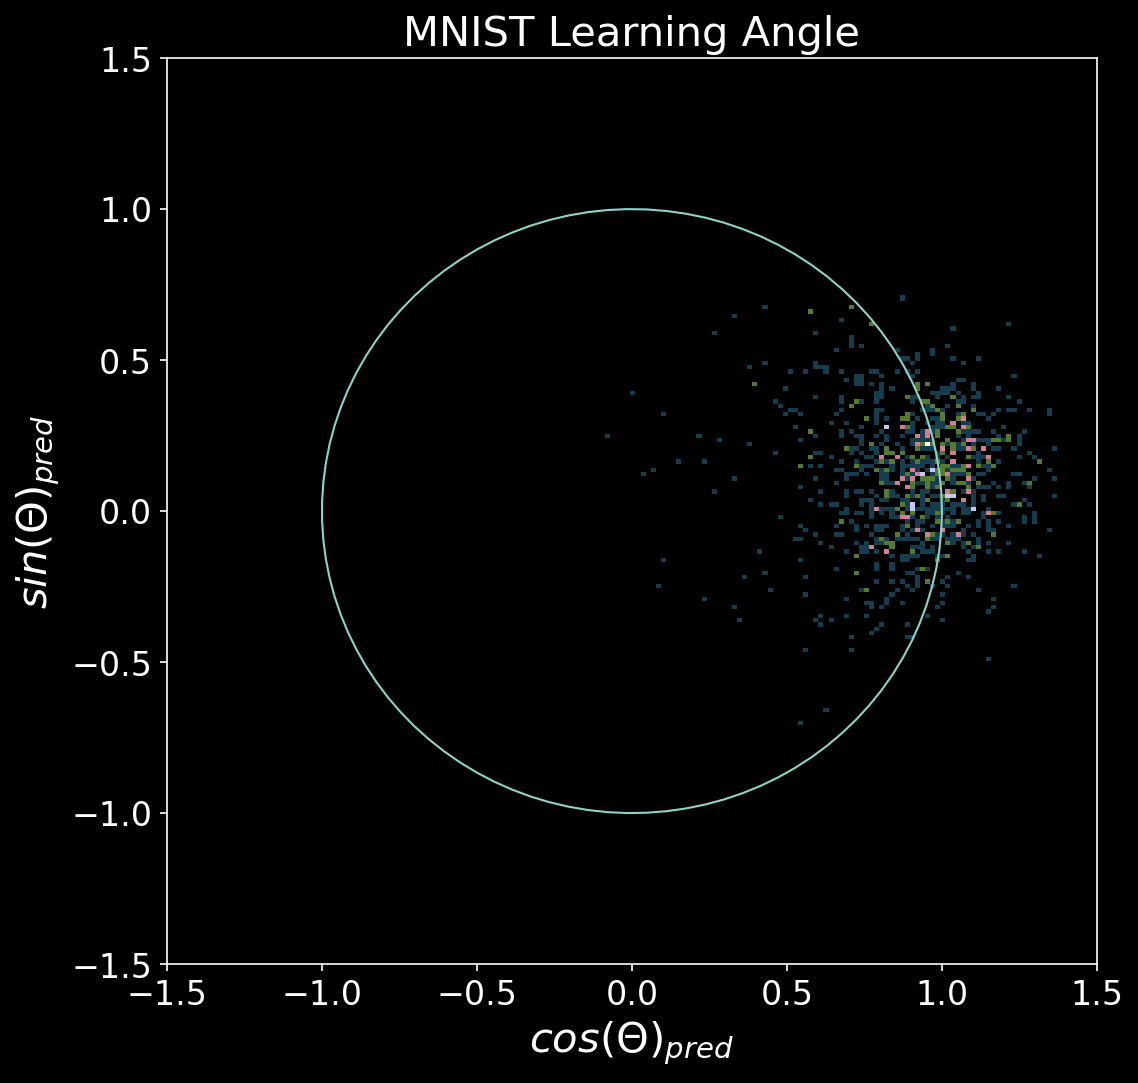

In [21]:
maskt = np.isin(angle_test[tst_slice],mnist_DHC_out_test_L4s_angles[0])

fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111) 
ax.hist2d(y_pred_testx[maskt,0], y_pred_testy[maskt,0],
          bins=[100,100],cmap='cubehelix')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
t = np.linspace(0,np.pi*2,100)
ax.plot(np.cos(t), np.sin(t), linewidth=1)
plt.ylabel('$sin(\Theta)_{pred}$')
plt.xlabel('$cos(\Theta)_{pred}$')
plt.title('MNIST Learning Angle')
plt.show()

In [75]:
NTrainSubset_list = [2,4,8,12,16,20,24]
std_class = np.zeros((len(NTrainSubset_list),10,5))
for i in range(len(NTrainSubset_list)):
    for j in tqdm(range(10)):
        NTrainSubset = NTrainSubset_list[i]
        idx = np.round(np.linspace(0, NtrainAngle - 1, NTrainSubset)).astype(int)
        
        sc = StandardScaler()
        tr_slice = np.logical_and(np.isin(angle_train,mnist_DHC_out_train_L4s_angles[idx]),np.isin(angle_train_class,j))
        tst_slice = np.isin(angle_test_class,j)
        
        X_trx = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
        Y_trx = np.array([
            np.cos(2*np.mod(angle_train[tr_slice],np.pi))
        ]).T

        X_testx = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
        Y_testx = np.array([
            np.cos(2*np.mod(angle_test[tst_slice],np.pi))
        ]).T

        reg = LinearRegression().fit(X_trx, Y_trx)
        y_pred_testx = reg.predict(X_testx)
        y_pred_trainx = reg.predict(X_trx)

        train_lossl2x = np.mean(np.square(y_pred_trainx-Y_trx))
        test_lossl2x = np.mean(np.square(y_pred_testx-Y_testx))

        X_try = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
        Y_try = np.array([
            np.sin(2*np.mod(angle_train[tr_slice],np.pi)),
        ]).T

        X_testy = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
        Y_testy = np.array([
            np.sin(2*np.mod(angle_test[tst_slice],np.pi))
        ]).T

        reg = LinearRegression().fit(X_try, Y_try)
        y_pred_testy = reg.predict(X_testy)
        y_pred_trainy = reg.predict(X_try)

        train_lossl2y = np.mean(np.square(y_pred_trainy-Y_try))
        test_lossl2y = np.mean(np.square(y_pred_testy-Y_testy))
        
        std_class[i,j,0] = train_lossl2x
        std_class[i,j,1] = test_lossl2x
        
        std_class[i,j,2] = train_lossl2y
        std_class[i,j,3] = test_lossl2y
        
        diff = 180*(np.arctan2(Y_testy[:,0],Y_testx[:,0])/np.pi-np.arctan2(y_pred_testy[:,0],y_pred_testx[:,0])/np.pi)
        diff[diff<-180]+=360
        diff[diff>180]-=360

        std_class[i,j,4] = np.std(diff)

100%|██████████| 10/10 [02:29<00:00, 15.00s/it]


In [76]:
hf = h5py.File('../scratch_AKS/data/equiv_workup_L4.h5', 'w')
hf.create_dataset('std_class', data=std_class)
hf.close()

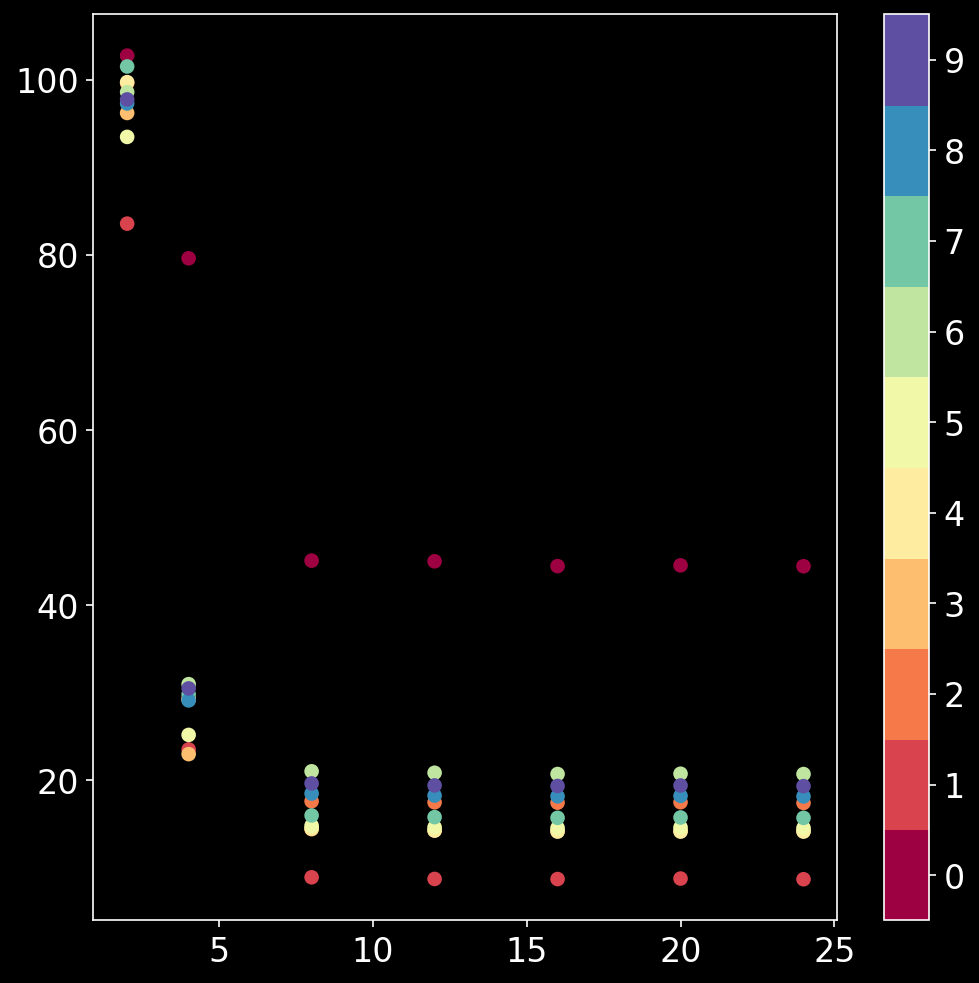

In [25]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class[:,i,4],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.xlim([5,25])
#plt.ylim([10,50])

In [77]:
NTrainSubset_list = [2,4,8,12,16]
std_class_both = np.zeros((len(NTrainSubset_list),10,9))
std_class_both_angle = np.zeros((len(NTrainSubset_list),10,NtestAngle))
for i in tqdm(range(len(NTrainSubset_list))):
    NTrainSubset = NTrainSubset_list[i]
    idx = np.round(np.linspace(0, NtrainAngle - 1, NTrainSubset)).astype(int)

    sc = StandardScaler()
    tr_slice = np.isin(angle_train,mnist_DHC_out_train_L4s_angles[idx])
    tst_slice = np.isin(angle_test_class,[0,1,2,3,4,5,6,7,8,9])

    X_trx = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
    Y_trx = np.array([
        np.cos(2*np.mod(angle_train[tr_slice],np.pi))
    ]).T

    X_testx = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
    Y_testx = np.array([
        np.cos(2*np.mod(angle_test[tst_slice],np.pi))
    ]).T

    reg = LinearRegression().fit(X_trx, Y_trx)
    y_pred_testx = reg.predict(X_testx)
    y_pred_trainx = reg.predict(X_trx)

    train_lossl2x = np.square(y_pred_trainx-Y_trx)
    test_lossl2x = np.square(y_pred_testx-Y_testx)

    X_try = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
    Y_try = np.array([
        np.sin(2*np.mod(angle_train[tr_slice],np.pi)),
    ]).T

    X_testy = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
    Y_testy = np.array([
        np.sin(2*np.mod(angle_test[tst_slice],np.pi))
    ]).T

    reg = LinearRegression().fit(X_try, Y_try)
    y_pred_testy = reg.predict(X_testy)
    y_pred_trainy = reg.predict(X_try)

    train_lossl2y = np.square(y_pred_trainy-Y_try)
    test_lossl2y = np.square(y_pred_testy-Y_testy)
    
    X_trc = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
    Y_trc = train_y_onehot[tr_slice]

    X_testc = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
    Y_testc = test_y_onehot[tst_slice]

    reg = LinearRegression().fit(X_trc, Y_trc)
    y_pred_testc = reg.predict(X_testc)
    y_pred_trainc = reg.predict(X_trc)

    train_lossl2c = np.square(y_pred_trainc-Y_trc)
    test_lossl2c = np.square(y_pred_testc-Y_testc)

    diff = 180*(np.arctan2(Y_testy[:,0],Y_testx[:,0])/np.pi-np.arctan2(y_pred_testy[:,0],y_pred_testx[:,0])/np.pi)
    diff[diff<-180]+=360
    diff[diff>180]-=360

    class_pred = np.argmax(y_pred_testc,axis=1)
    y_class = angle_test_class[tst_slice]
    cmat = cm_eval(class_pred,y_class,10)
    
    for j in range(10):
        masktst = np.isin(angle_test_class[tst_slice],j)
        masktr = np.isin(angle_train_class[tr_slice],j)
        
        for indxl, l in enumerate(mnist_DHC_out_test_L4s_angles):
            masktst_l = np.logical_and(np.isin(angle_test_class[tst_slice],j),np.isin(angle_test[tst_slice],l))
            std_class_both_angle[i,j,indxl] = np.count_nonzero(class_pred[masktst_l]==j)/np.count_nonzero(y_class[masktst_l]==j)
        
        std_class_both[i,j,0] = np.mean(train_lossl2x[masktr])
        std_class_both[i,j,1] = np.mean(test_lossl2x[masktst])
        std_class_both[i,j,2] = np.mean(train_lossl2y[masktr])
        std_class_both[i,j,3] = np.mean(test_lossl2y[masktst])  
        std_class_both[i,j,4] = np.mean(train_lossl2c[masktr,j])
        std_class_both[i,j,5] = np.mean(test_lossl2c[masktst,j])  
        std_class_both[i,j,6] = np.std(diff[masktst])
        std_class_both[i,j,7] = cmat[j,j]/np.count_nonzero(masktst)
        std_class_both[i,j,8] = np.std(std_class_both_angle[i,j,:])

100%|██████████| 5/5 [09:41<00:00, 116.33s/it]


In [78]:
hf = h5py.File('../scratch_AKS/data/equiv_workup_L4.h5', 'w')
hf.create_dataset('std_class_both', data=std_class_both)
hf.close()

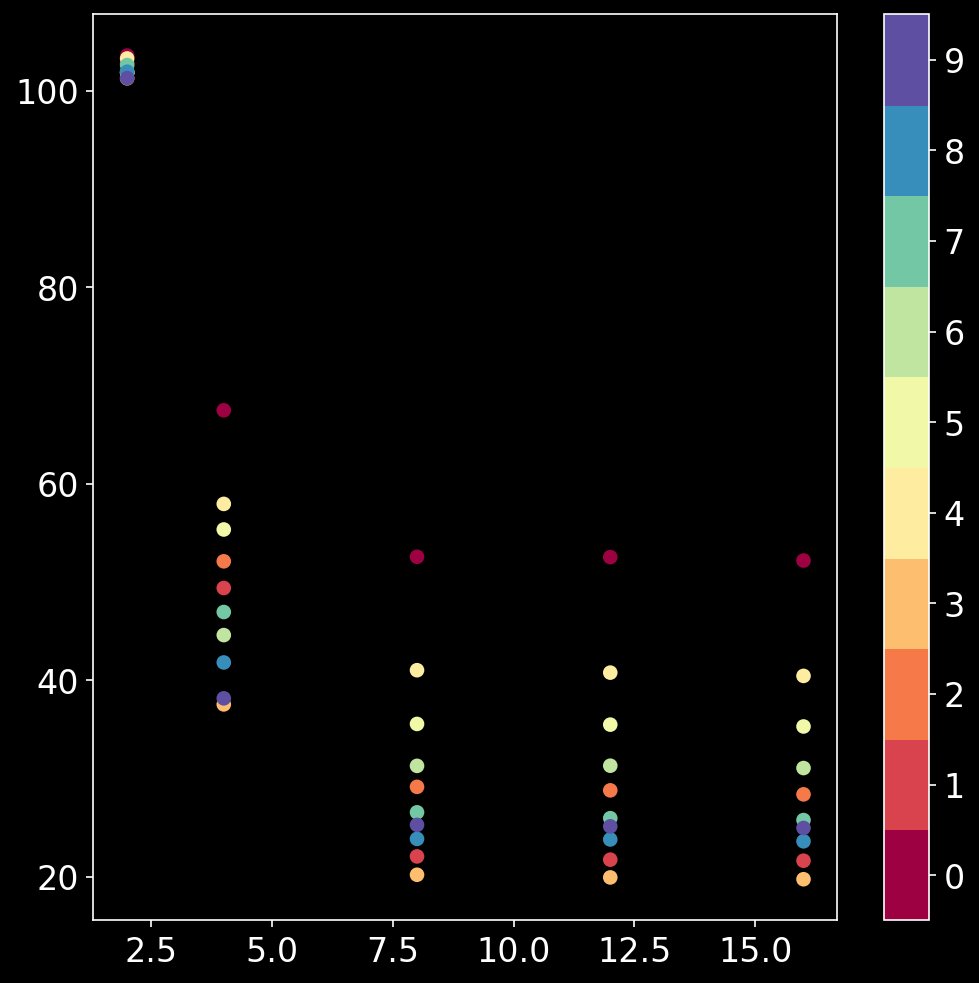

In [23]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class_both[:,i,6],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.xlim([5,25])
#plt.ylim([10,50])

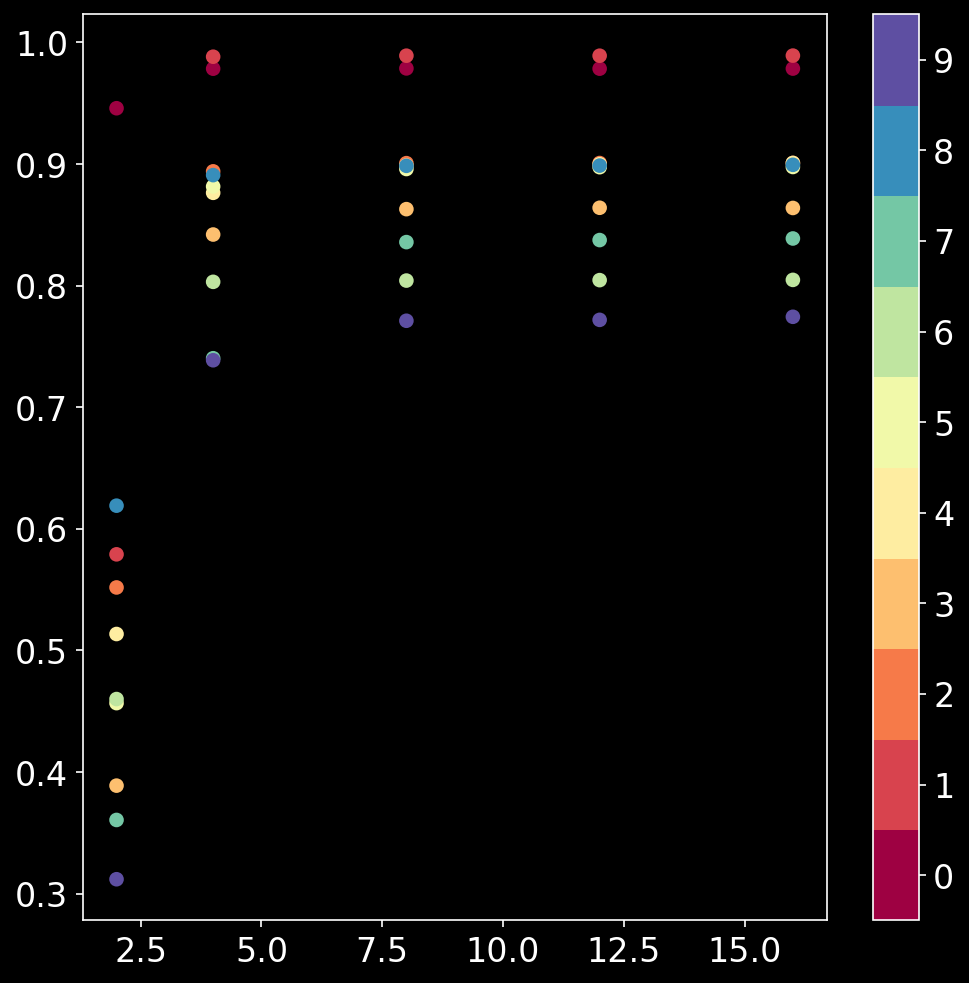

In [24]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,std_class_both[:,i,7],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.xlim([5,25])
#plt.ylim([10,50])

(0.0, 5.0)

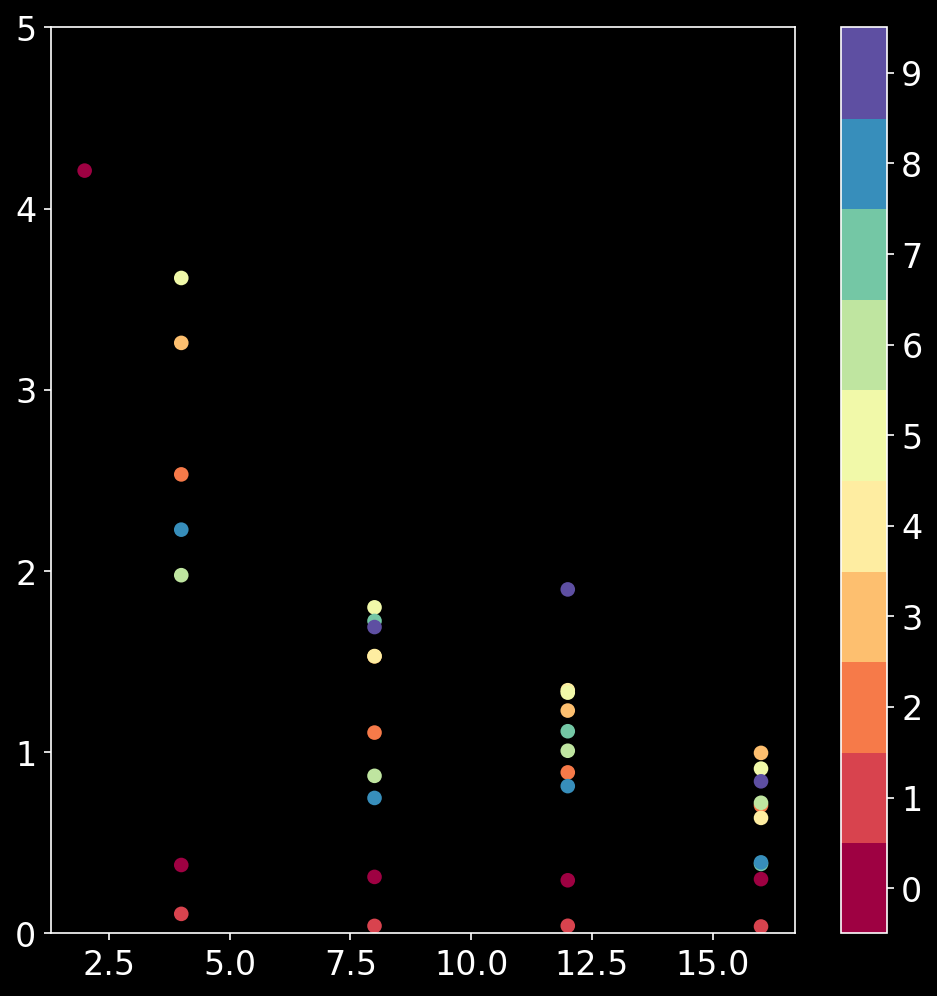

In [28]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(NTrainSubset_list,100*std_class_both[:,i,8],c=i*np.ones(len(NTrainSubset_list)),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.xlim([5,25])
plt.ylim([0,5])

In [42]:
mnist_DHC_out_test_L4s_angles.shape

(48,)

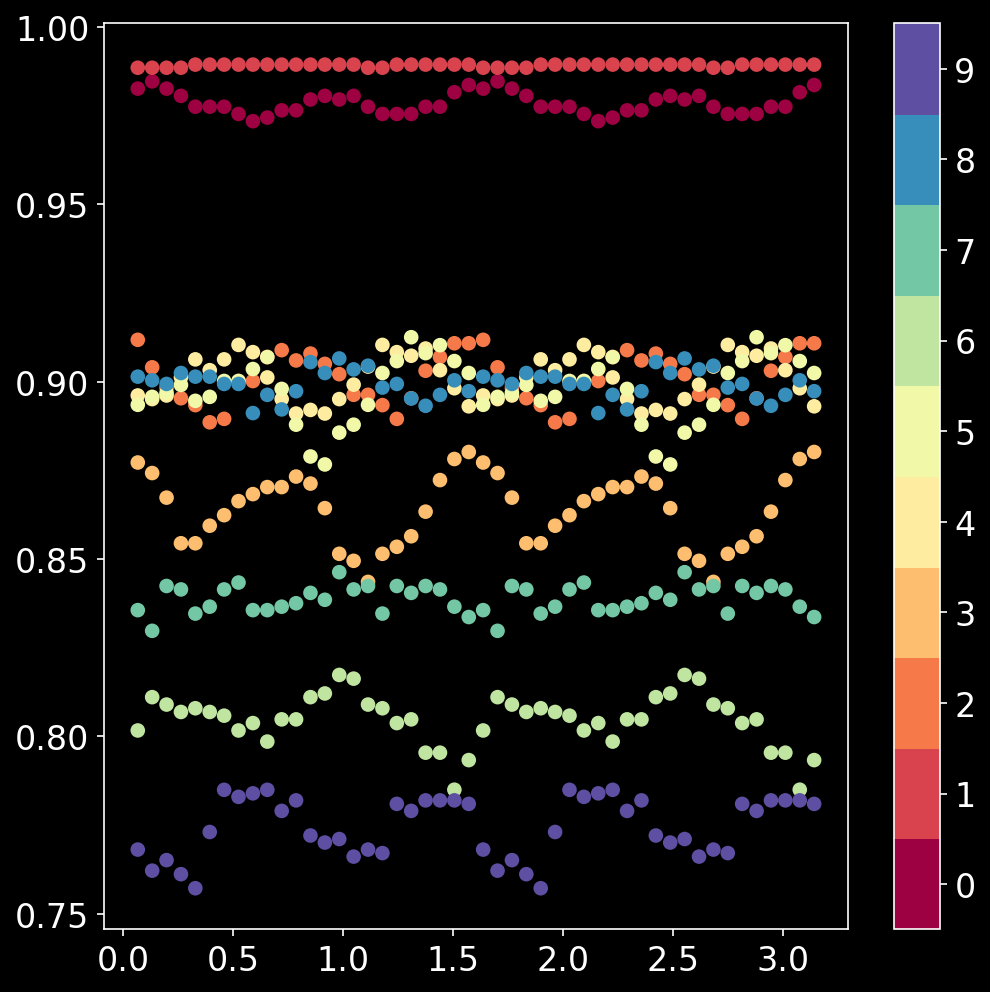

In [46]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(mnist_DHC_out_test_L4s_angles,std_class_both_angle[4,i,:],c=i*np.ones(NtestAngle),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.xlim([5,25])
#plt.ylim([0,5])

In [73]:
std_class_ref = np.zeros((NtrainAngle,10,3))
for i in tqdm(range(NtrainAngle)):
    sc = StandardScaler()
    tr_slice = np.isin(angle_train,mnist_DHC_out_train_L4s_angles[i])
    tst_slice = np.isin(angle_test,mnist_DHC_out_train_L4s_angles[i])

    X_trc = sc.fit_transform(np.log10(mnist_DHC_out_train_L4s[tr_slice]))
    Y_trc = train_y_onehot[tr_slice]

    X_testc = sc.transform(np.log10(mnist_DHC_out_test_L4s[tst_slice]))
    Y_testc = test_y_onehot[tst_slice]

    reg = LinearRegression().fit(X_trc, Y_trc)
    y_pred_testc = reg.predict(X_testc)
    y_pred_trainc = reg.predict(X_trc)

    train_lossl2c = np.square(y_pred_trainc-Y_trc)
    test_lossl2c = np.square(y_pred_testc-Y_testc)
    
    class_pred = np.argmax(y_pred_testc,axis=1)
    y_class = angle_test_class[tst_slice]
    cmat = cm_eval(class_pred,y_class,10)
    
    for j in range(10):
        masktst = np.isin(angle_test_class[tst_slice],j)
        masktr = np.isin(angle_train_class[tr_slice],j)

        std_class_ref[i,j,0] = np.mean(train_lossl2c[masktr,j])
        std_class_ref[i,j,1] = np.mean(test_lossl2c[masktst,j])  
        std_class_ref[i,j,2] = cmat[j,j]/np.count_nonzero(masktst)

100%|██████████| 24/24 [02:14<00:00,  5.61s/it]


In [74]:
hf = h5py.File('../scratch_AKS/data/equiv_workup_L4.h5', 'w')
hf.create_dataset('std_class_ref', data=std_class_ref)
hf.close()

In [54]:
std_class_ref[:,1].shape, mnist_DHC_out_train_L4s_angles.shape

((24, 3), (24,))

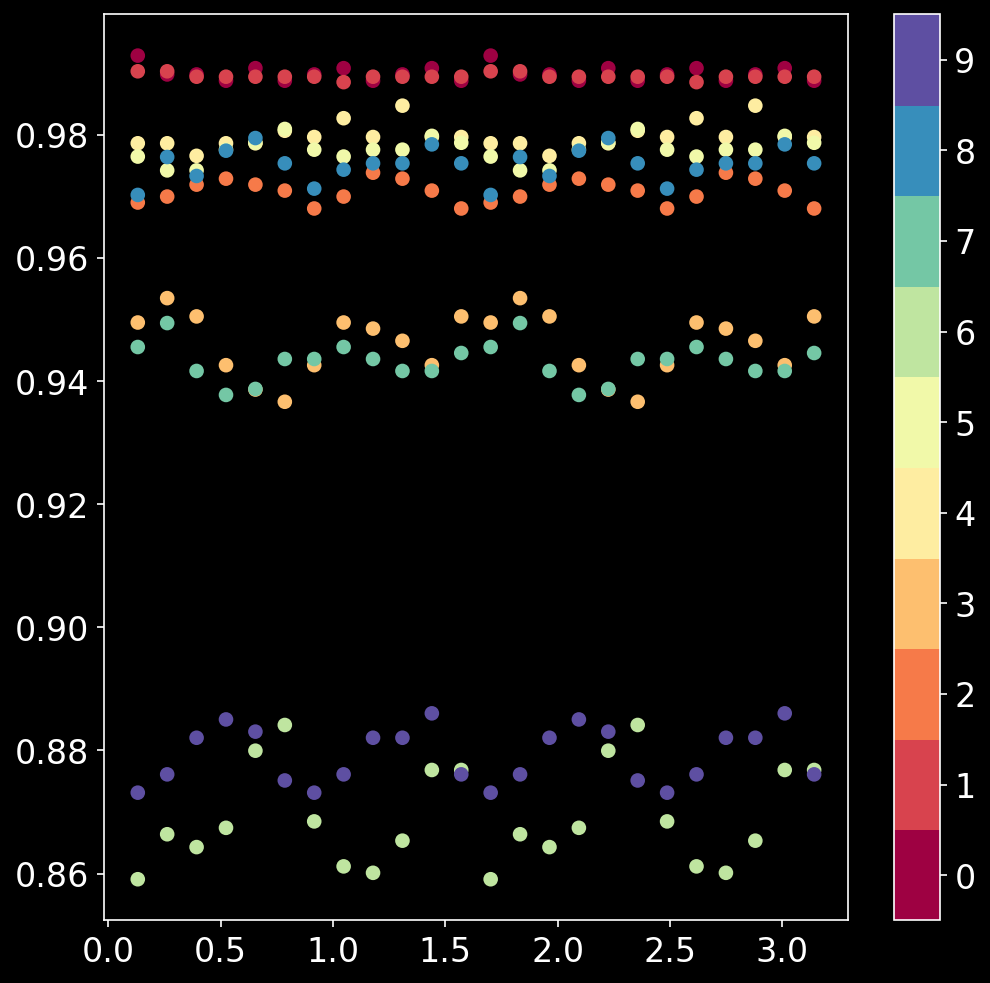

In [55]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
for i in range(10):
    sc = ax.scatter(mnist_DHC_out_train_L4s_angles,std_class_ref[:,i,2],c=i*np.ones(NtrainAngle),cmap='Spectral',vmin=0,vmax=9)
plt.colorbar(sc,boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
#plt.xlim([5,25])
#plt.ylim([0,5])

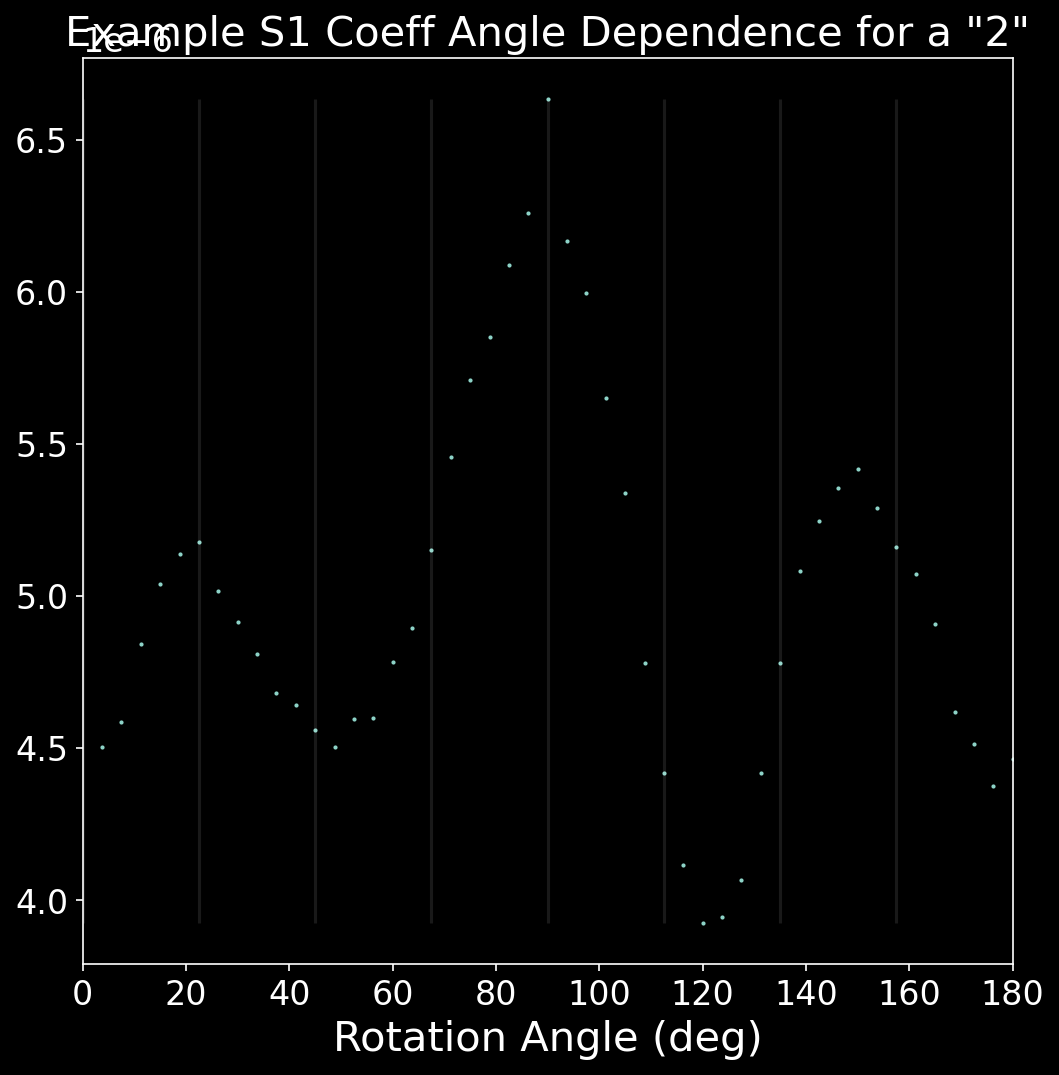

In [158]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
k=1
data = mnist_DHC_out_test_L4s[48*k:48*(k+1),2+5*4+1]
plt.scatter(angle_test[48*k:48*(k+1)]*180/np.pi,data,s=1)

min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w', alpha=0.1)

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

In [159]:
from scipy import interpolate
x_interp = angle_test[range(48*k,48*(k+1),6)]*180/np.pi
x_interp = np.append(x_interp,180+x_interp[0])
y_interp = mnist_DHC_out_test_L4s[range(48*k,48*(k+1),6),:]
y_interp = np.vstack((y_interp,y_interp[0,:]))
f = interpolate.CubicSpline(x_interp,y_interp,axis=0,bc_type='periodic')
#f = interpolate.interp1d(x_interp,y_interp,axis=0,fill_value='extrapolate')

In [160]:
ext_y = f(angle_test[48*k:48*(k+1)]*180/np.pi)

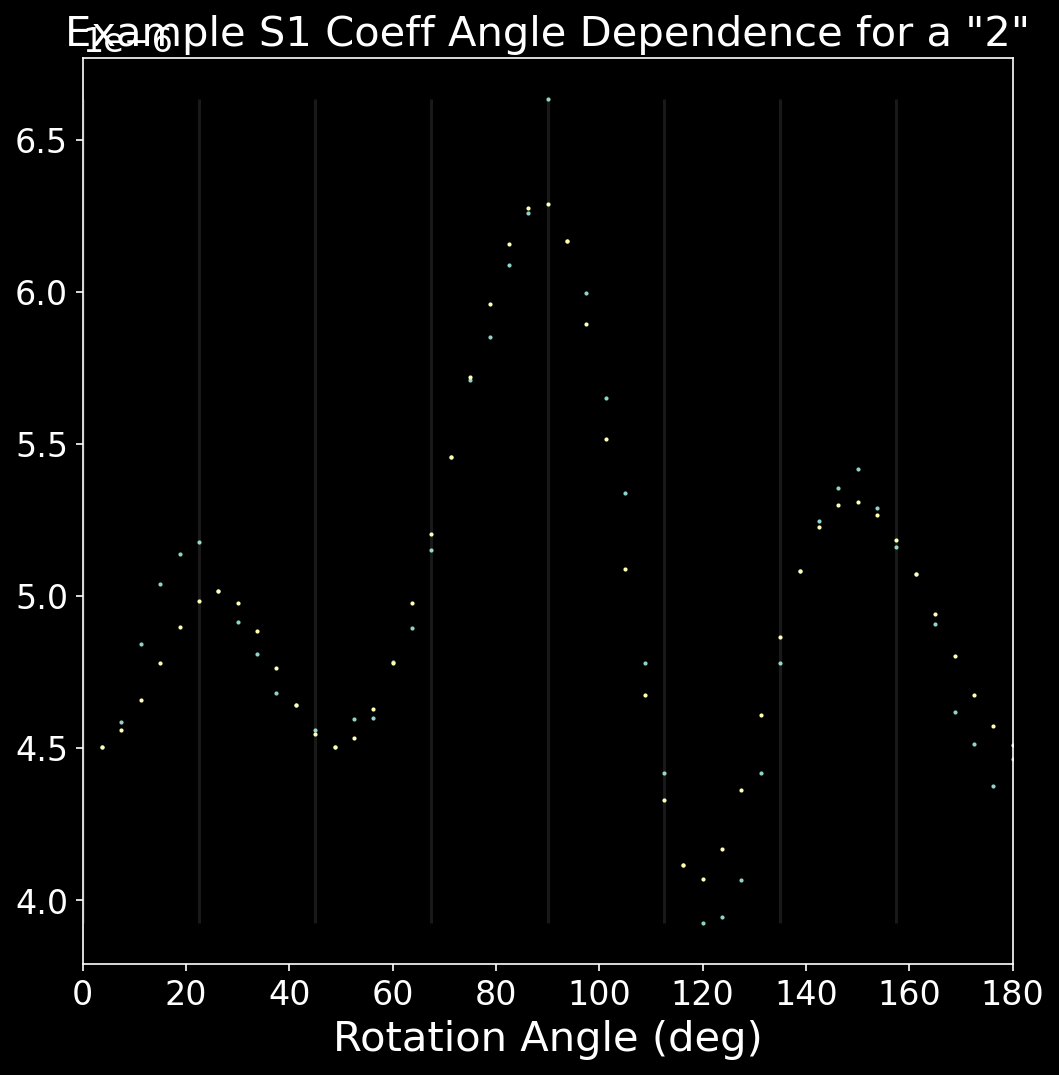

In [161]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
k=1
data = mnist_DHC_out_test_L4s[48*k:48*(k+1),2+5*4+1]

plt.scatter(angle_test[48*k:48*(k+1)]*180/np.pi,data,s=1)

data1 = ext_y[:,2+5*4+1]

plt.scatter(angle_test[48*k:48*(k+1)]*180/np.pi,data1,s=1)

min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w',alpha=0.1)

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

In [177]:
L=4
J=5
indx_list = np.zeros(mnist_DHC_out_test_L4s.shape[1],dtype=np.int)
indx_list[1] = 1
for j in range(J):
    for l in range(L):
        indx_list[2+j+5*l] = 2+j+J*np.remainder(l+1,L)
for j

In [212]:
##DID NOT FINSIH, JUST DID IN JULIA

def DHC_shift(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    indx_list = np.zeros(mnist_DHC_out_test_L4s.shape[1],dtype=np.int)
    indx_list[1] = 1
    
    for j1 in range(J):
        for l1 in range(L):
            indx_list[2+j+J*l] = 2+j+J*np.remainder(l+1,L)
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [184]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
import julia
from julia import Main
import julia.Base
import DHC_2DUtils

ModuleNotFoundError: No module named 'DHC_2DUtils'

In [185]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [214]:
%%julia
push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
import DHC_2DUtils
using SparseArrays
using HDF5

In [202]:
%%julia
function S1_equiv_matrix(fhash,l_shift)
        # fhash is the filter hash output by fink_filter_hash
        # The output matrix converts an S1 coeff vector to S1iso by
        #   summing over l
        # Matrix is stored in sparse CSC format using SparseArrays.
        # DPF 2021-Feb-18

        # Does hash contain Omega filter?
        Omega   = haskey(fhash, "Omega_index")
        if Omega Ω_ind = fhash["Omega_index"] end

        # unpack fhash
        Nl      = length(fhash["theta_value"])
        Nj      = length(fhash["j_value"])
        Nf      = length(fhash["filt_value"])
        ψ_ind   = fhash["psi_index"]
        ϕ_ind   = fhash["phi_index"]

        # number of iso coefficients
        Niso    = Omega ? Nj+2 : Nj+1
        Mat     = zeros(Int32, Nf, Nf)

        # first J elements of iso
        for j = 1:Nj
            for l = 1:Nl
                λ = ψ_ind[j,l]
                λ1 = ψ_ind[j,mod1(l+l_shift,Nl)]
                Mat[λ1, λ] = 1
            end
        end

        # Next elements are ϕ, Ω
        Mat[ϕ_ind, ϕ_ind] = 1
        if Omega Mat[Ω_ind, Ω_ind] = 1 end

        return sparse(Mat)
    end

<PyCall.jlwrap S1_equiv_matrix>

In [206]:
%%julia
filter_hash = DHC_2DUtils.fink_filter_hash(1, 4, nx=128, pc=1, wd=2)
S1_equiv_matrix(filter_hash,1)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

In [203]:
%%julia
    function S2_equiv_matrix(fhash,l_shift)
        # fhash is the filter hash output by fink_filter_hash
        # The output matrix converts an S2 coeff vector to S2iso by
        #   summing over l1,l2 and fixed Δl.
        # Matrix is stored in sparse CSC format using SparseArrays.
        # DPF 2021-Feb-18

        # Does hash contain Omega filter?
        Omega   = haskey(fhash, "Omega_index")
        if Omega Ω_ind = fhash["Omega_index"] end

        # unpack fhash
        Nl      = length(fhash["theta_value"])
        Nj      = length(fhash["j_value"])
        Nf      = length(fhash["filt_value"])
        ψ_ind   = fhash["psi_index"]
        ϕ_ind   = fhash["phi_index"]

        # number of iso coefficients
        Niso    = Omega ? Nj*Nj*Nl+4*Nj+4 : Nj*Nj*Nl+2*Nj+1
        Mat     = zeros(Int32, Nf*Nf, Nf*Nf)

        # first J*J*L elements of iso
        for j1 = 1:Nj
            for j2 = 1:Nj
                for l1 = 1:Nl
                    for l2 = 1:Nl
                        λ1     = ψ_ind[j1,l1]
                        λ2     = ψ_ind[j2,l2]
                        λ1_new     = ψ_ind[j1,mod1(l1+l_shift,Nl)]
                        λ2_new     = ψ_ind[j2,mod1(l2+l_shift,Nl)]

                        Icoeff = λ1+Nf*(λ2-1)
                        Icoeff_new = λ1_new+Nf*(λ2_new-1)
                        Mat[Icoeff_new, Icoeff] = 1
                    end
                end
            end
        end

        # Next J elements are λϕ, then J elements ϕλ
        for j = 1:Nj
            for l = 1:Nl
                λ      = ψ_ind[j,l]
                Icoeff = λ+Nf*(ϕ_ind-1)  # λϕ
                
                λ_new      = ψ_ind[j,mod1(l+l_shift,Nl)]
                Icoeff_new = λ_new+Nf*(ϕ_ind-1)  # λϕ
                
                Mat[Icoeff_new, Icoeff] = 1

                Icoeff = ϕ_ind+Nf*(λ-1)  # ϕλ
                Icoeff_new = ϕ_ind+Nf*(λ_new-1)  # ϕλ
                Mat[Icoeff_new, Icoeff] = 1
            end
        end

        # Next 1 element is ϕϕ
        Icoeff = ϕ_ind+Nf*(ϕ_ind-1)
        Mat[Icoeff, Icoeff] = 1

        # If the Omega filter exists, add more terms
        if Omega
            # Next J elements are λΩ, then J elements Ωλ
            for j = 1:Nj
                for l = 1:Nl
                    λ      = ψ_ind[j,l]
                    λ_new      = ψ_ind[j,mod1(l+l_shift,Nl)]
                    Icoeff = λ+Nf*(Ω_ind-1)  # λΩ
                    Icoeff_new = λ_new+Nf*(Ω_ind-1)  # λΩ
                    Mat[Icoeff_new, Icoeff] = 1

                    Iiso   = I0+Nj+j
                    Icoeff = Ω_ind+Nf*(λ-1)  # Ωλ
                    Icoeff_new = Ω_ind+Nf*(λ_new-1)  # Ωλ
                    Mat[Icoeff_new, Icoeff] = 1
                end
            end
            # Next 3 elements are ϕΩ, Ωϕ, ΩΩ
            Mat[ϕ_ind+Nf*(Ω_ind-1), ϕ_ind+Nf*(Ω_ind-1)] = 1
            Mat[Ω_ind+Nf*(ϕ_ind-1), Ω_ind+Nf*(ϕ_ind-1)] = 1
            Mat[Ω_ind+Nf*(Ω_ind-1), Ω_ind+Nf*(Ω_ind-1)] = 1
        end

        return sparse(Mat)
    end

<PyCall.jlwrap S2_equiv_matrix>

In [207]:
%%julia
filter_hash = DHC_2DUtils.fink_filter_hash(1, 4, nx=128, pc=1, wd=2)
size(S2_equiv_matrix(filter_hash,1))

(441, 441)

In [210]:
%%julia
filter_hash = DHC_2DUtils.fink_filter_hash(1, 4, nx=128, pc=1, wd=2)
size(S1_equiv_matrix(filter_hash,1))

(21, 21)

In [223]:
%%julia
mnist_DHC_out_test_L4s = h5read("../from_cannon/2021_03_09/mnist_DHC_test_eq_L4_s.h5","main/data")
filter_hash = DHC_2DUtils.fink_filter_hash(1, 4, nx=128, pc=1, wd=2)
S1mat = S1_equiv_matrix(filter_hash,1)
S2mat = S2_equiv_matrix(filter_hash,1)

In [225]:
%%julia
size(mnist_DHC_out_test_L4s)

(464, 480000)

In [227]:
%%julia
coeff_out = DHC_2DUtils.isoMaker(transpose(mnist_DHC_out_test_L4s),S1mat,S2mat);

In [228]:
%%julia
size(coeff_out)

(480000, 464)

In [232]:
coeff_out = np.array(Main.eval("coeff_out"))

In [233]:
coeff_out

(480000, 464)

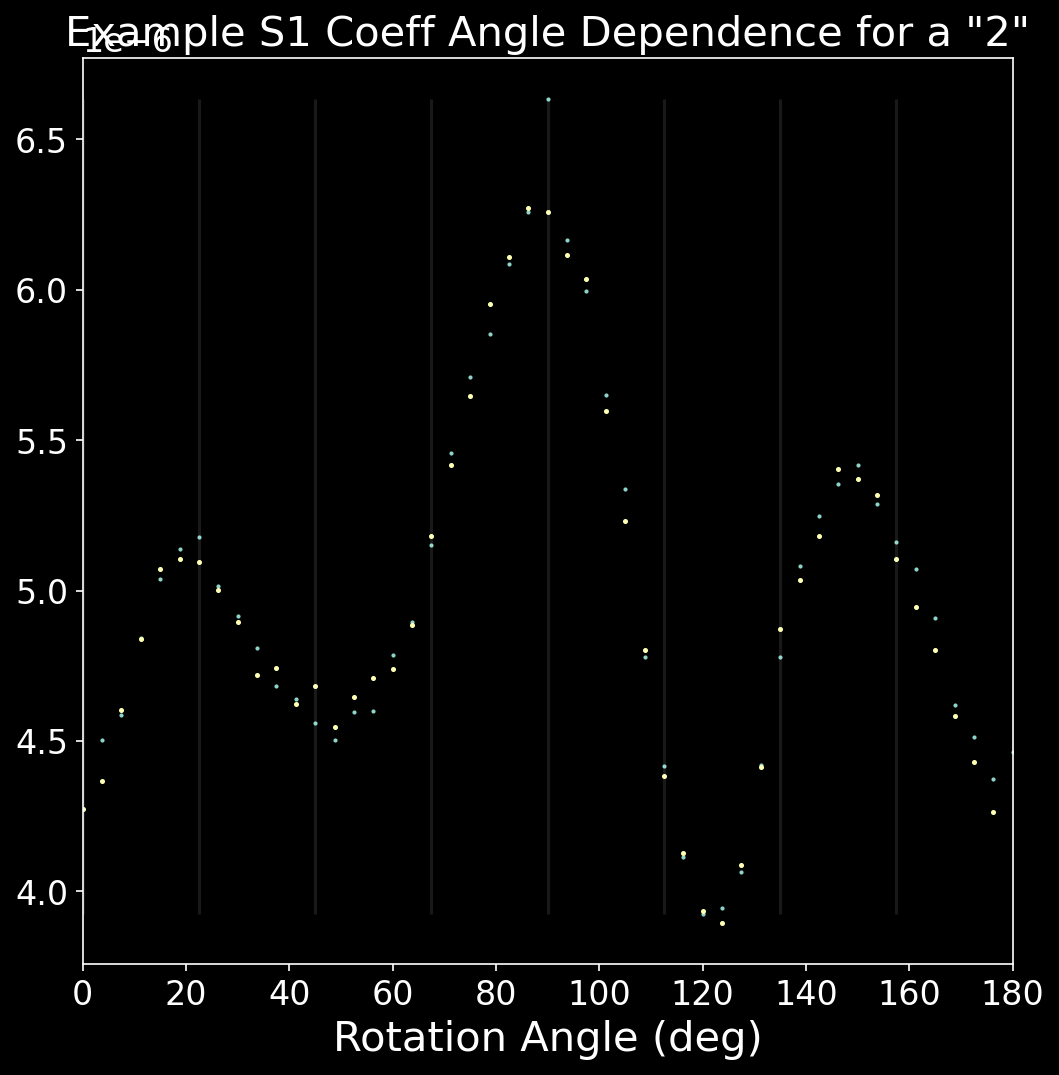

In [290]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
k=1
data = mnist_DHC_out_test_L4s[48*k:48*(k+1),2+5*4+1]
data1 = coeff_out[48*k:48*(k+1),2+5*4+1]

plt.scatter(angle_test[48*k:48*(k+1)]*180/np.pi,data,s=1)
plt.scatter(np.remainder(angle_test[48*k:48*(k+1)]*180/np.pi+180/4,180),data1,s=2)

min_y = data.min()
max_y = data.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w', alpha=0.1)

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

Ok, almost done with this part of the pipeline.

In [7]:
from julia.api import Julia
jl = Julia(compiled_modules=False)
import julia
from julia import Main
import julia.Base
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [8]:
%%julia
push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")
import DHC_2DUtils
using SparseArrays
using HDF5

In [9]:
%%julia
test = []
for i=1:3
    push!(test,i)
end
test

[1, 2, 3]

In [13]:
%%julia
mnist_DHC_out_test_L4s = h5read("../from_cannon/2021_03_09/mnist_DHC_test_eq_L4_s.h5","main/data")
filter_hash = DHC_2DUtils.fink_filter_hash(1, 4, nx=128, pc=1, wd=2)
sizeTarget = size(transpose(mnist_DHC_out_test_L4s))
shifted_coeff = zeros(4,sizeTarget[1],sizeTarget[2])
for i=1:4
    S1mat = DHC_2DUtils.S1_equiv_matrix(filter_hash,i)
    S2mat = DHC_2DUtils.S2_equiv_matrix(filter_hash,i)
    shifted_coeff[i,:,:] = DHC_2DUtils.trasformMaker(transpose(mnist_DHC_out_test_L4s),S1mat,S2mat)
end

In [14]:
shifted_coeff = np.array(Main.eval("shifted_coeff"))

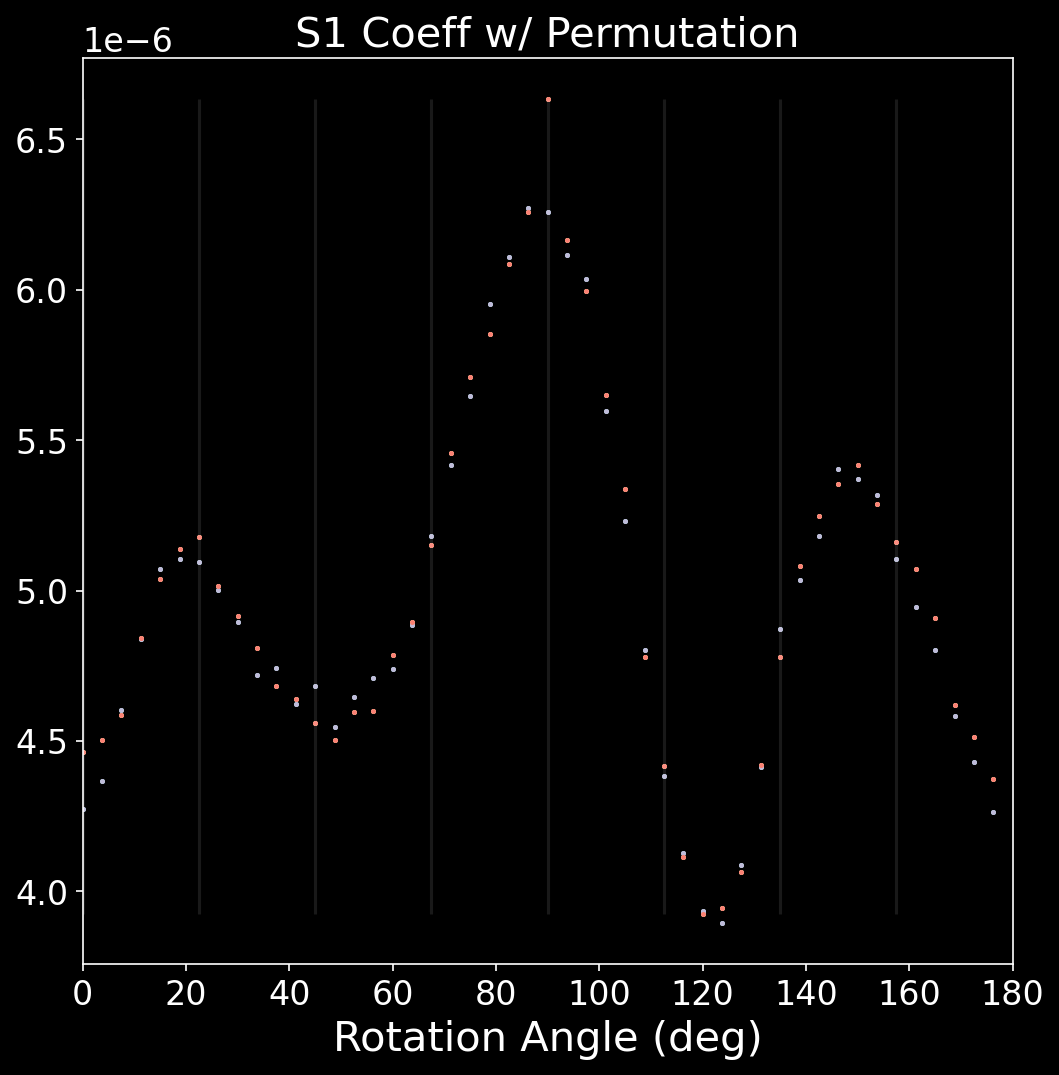

In [82]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
k=1
for i in range(4):
    data1 = shifted_coeff[i,48*k:48*(k+1),2+5*4+1]
    plt.scatter(np.remainder(angle_test[48*k:48*(k+1)]*180/np.pi+(i+1)*180/4,180),data1,s=2)

min_y = data1.min()
max_y = data1.max()

for i in range(0,8):
    plt.vlines(i*180/8,min_y,max_y,'w', alpha=0.1)

plt.title('S1 Coeff w/ Permutation')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

In [291]:
from scipy import interpolate
x_interp = np.array([mnist_DHC_out_test_L4s_angles[0]+i*np.pi/4 for i in range(4)])*180/np.pi
x_interp = np.append(x_interp,180+x_interp[0])
list_test = [mnist_DHC_out_test_L4s,shifted_coeff[0],shifted_coeff[1],shifted_coeff[2]]
y_interp = np.array([x[48*k,:] for x in list_test])
y_interp = np.vstack((y_interp,y_interp[0,:]))
f = interpolate.CubicSpline(x_interp,y_interp,axis=0,bc_type='periodic')
#f = interpolate.interp1d(x_interp,y_interp,axis=0,fill_value='extrapolate')

In [292]:
y_interp.shape

(5, 464)

In [293]:
ext_y = f(angle_test[48*k:48*(k+1)]*180/np.pi)

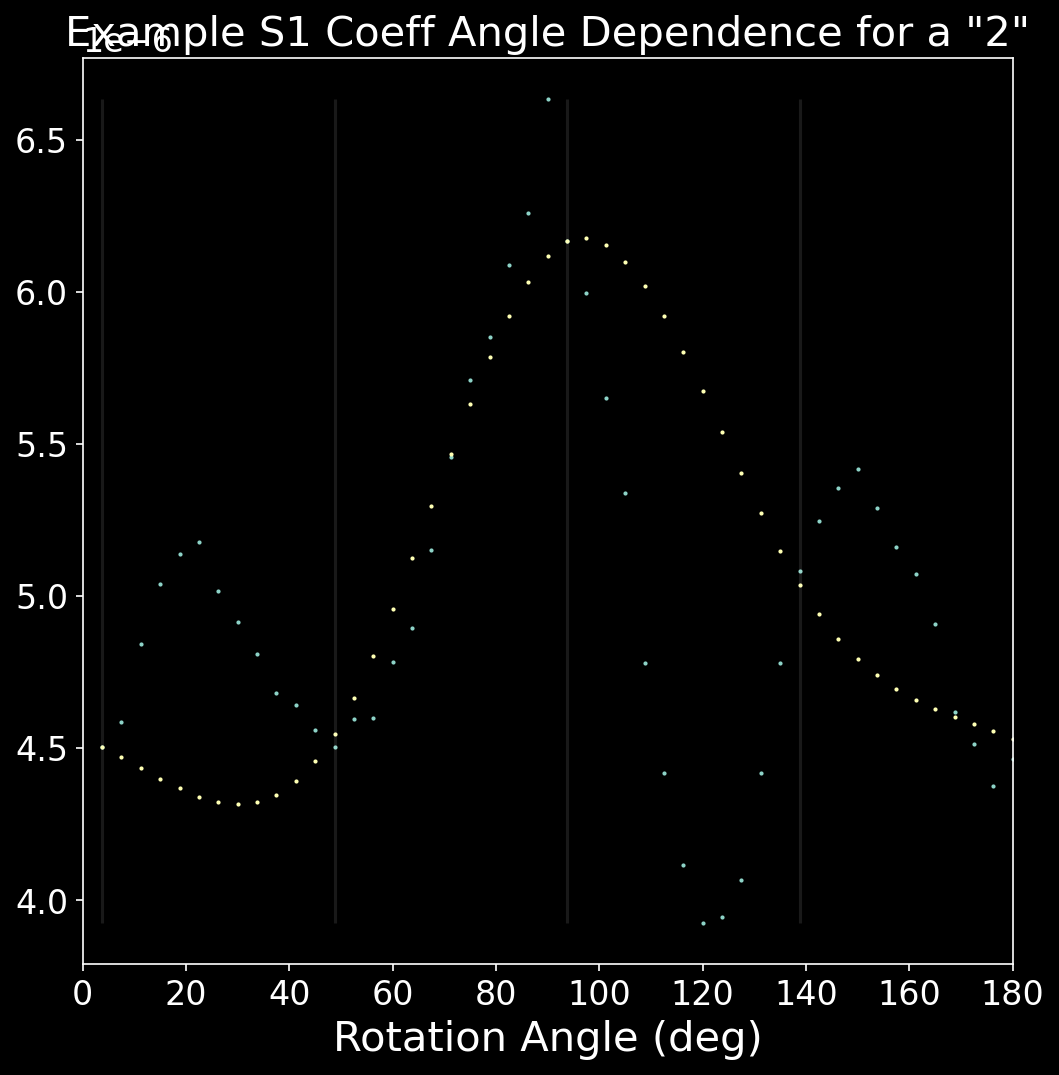

In [294]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
k=1
data = mnist_DHC_out_test_L4s[48*k:48*(k+1),2+5*4+1]

plt.scatter(angle_test[48*k:48*(k+1)]*180/np.pi,data,s=1)

data1 = ext_y[:,2+5*4+1]

plt.scatter(angle_test[48*k:48*(k+1)]*180/np.pi,data1,s=1)

min_y = data.min()
max_y = data.max()

for i in x_interp:
    plt.vlines(i,min_y,max_y,'w',alpha=0.1)

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

Now all I have to do is figure out how to do that over all coeff over all test images and all angle choices and then over all L

In [19]:
# x_interp = np.zeros((4,angle_test.shape[0]))
# for i in range(4):
#     x_interp[i,:] = angle_test+(i+1)*np.pi/4
# x_interp = np.vstack((x_interp,np.pi+x_interp[0,:]))

In [15]:
from scipy import interpolate

In [51]:
equiv_std = np.zeros((len(angle_test),2))

x_for_compare = mnist_DHC_out_test_L4s_angles*180/np.pi
for j in tqdm(range(len(angle_test))):
    k = np.floor_divide(j,48)
    x_interp = np.array([angle_test[j]+(i+1)*np.pi/4 for i in range(4)])*180/np.pi
    x_interp = np.append(x_interp,180+x_interp[0])
    y_interp = shifted_coeff[:,j,:]
    y_interp = np.vstack((y_interp,y_interp[0,:].reshape(1,y_interp.shape[1])))
    f = interpolate.CubicSpline(x_interp,y_interp,axis=0,bc_type='periodic')
    ext_y = f(x_for_compare)
    real_y = mnist_DHC_out_test_L4s[48*k:48*(k+1),:]
    diff = ext_y-real_y
    max_val = np.amax([ext_y,real_y],axis=0)
    equiv_std[j,0] = np.mean(np.abs(np.divide(diff,max_val)))
    equiv_std[j,1] = np.mean(np.abs(diff))

100%|██████████| 480000/480000 [07:22<00:00, 1085.33it/s]


In [72]:
hf = h5py.File('../scratch_AKS/data/equiv_workup_L4.h5', 'w')
hf.create_dataset('equiv_std', data=equiv_std)
hf.close()

In [89]:
angle_test.shape

(480000,)

In [90]:
j=480000-1
x_interp = np.array([angle_test[j]+(i+1)*np.pi/4 for i in range(4)])*180/np.pi

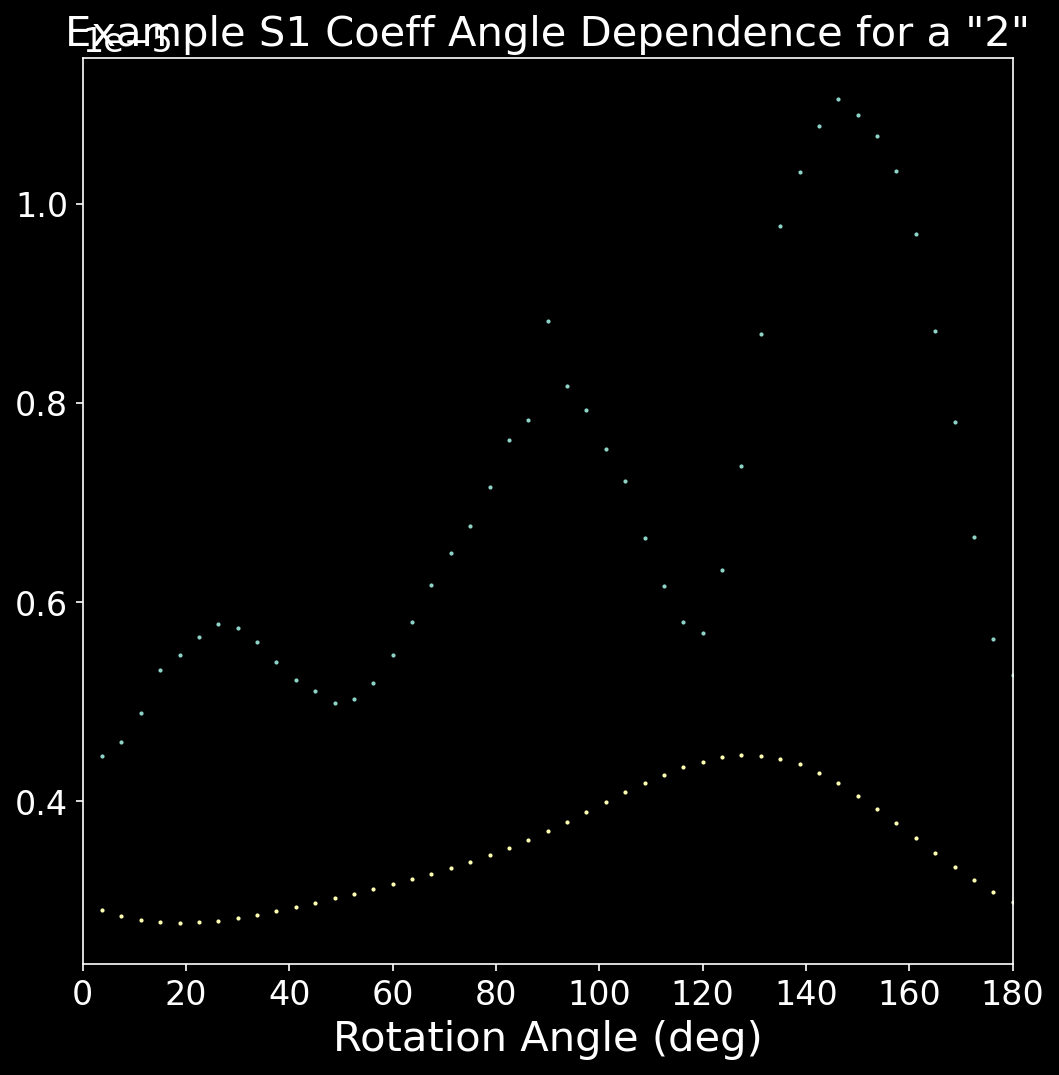

In [91]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
k=0
data = mnist_DHC_out_test_L4s[48*k:48*(k+1),2+5*4+1]

plt.scatter(x_for_compare,data,s=1)

data1 = ext_y[:,2+5*4+1]

plt.scatter(x_for_compare,data1,s=1)

min_y = data.min()
max_y = data.max()

for i in x_interp:
    plt.vlines(i,min_y,max_y,'w',alpha=0.1)

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

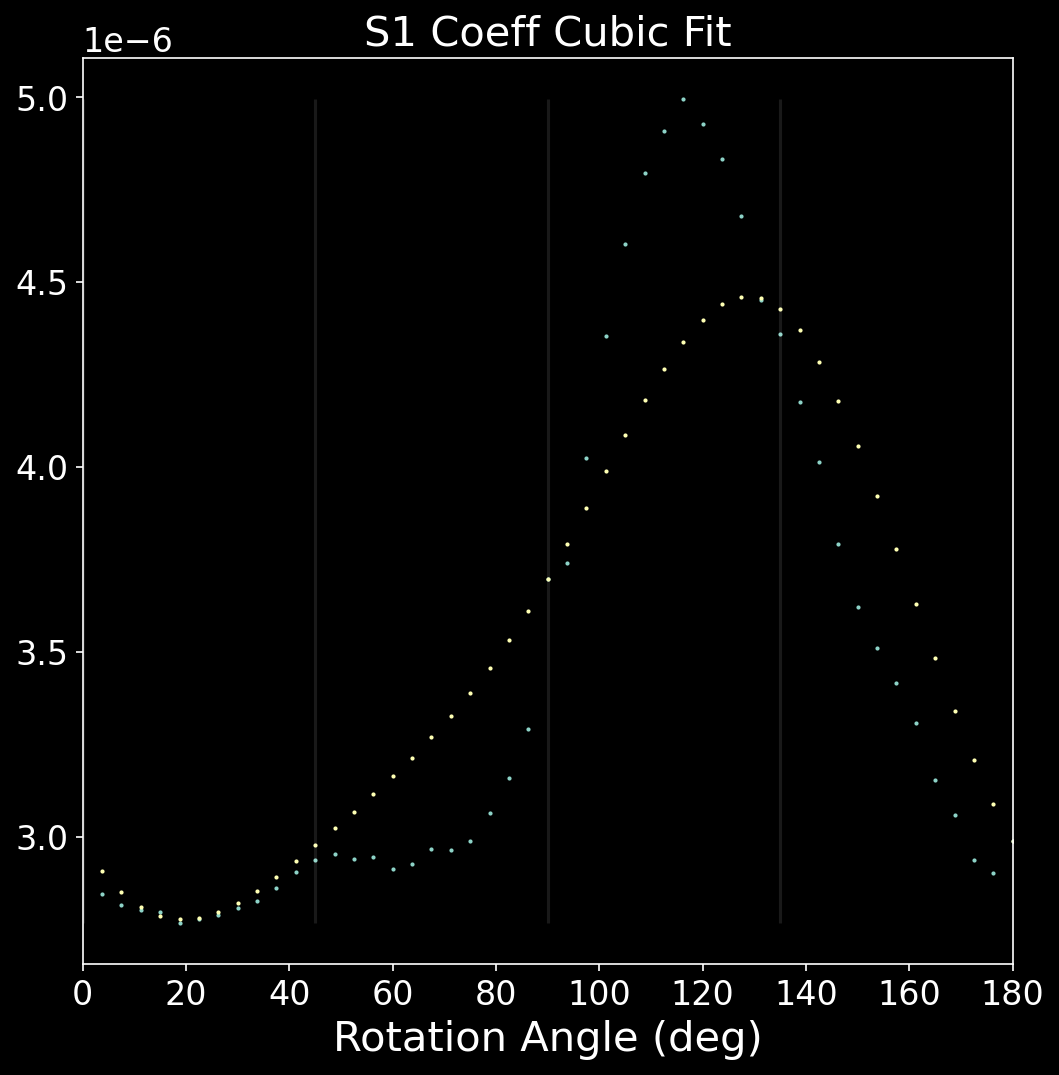

In [93]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
plt.scatter(x_for_compare,real_y[:,2+5*4+1],s=1)
plt.scatter(x_for_compare,ext_y[:,2+5*4+1],s=1)

min_y = real_y[:,2+5*4+1].min()
max_y = real_y[:,2+5*4+1].max()

for i in np.remainder(x_interp,180):
    plt.vlines(i,min_y,max_y,'w',alpha=0.1)

plt.title('S1 Coeff Cubic Fit')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

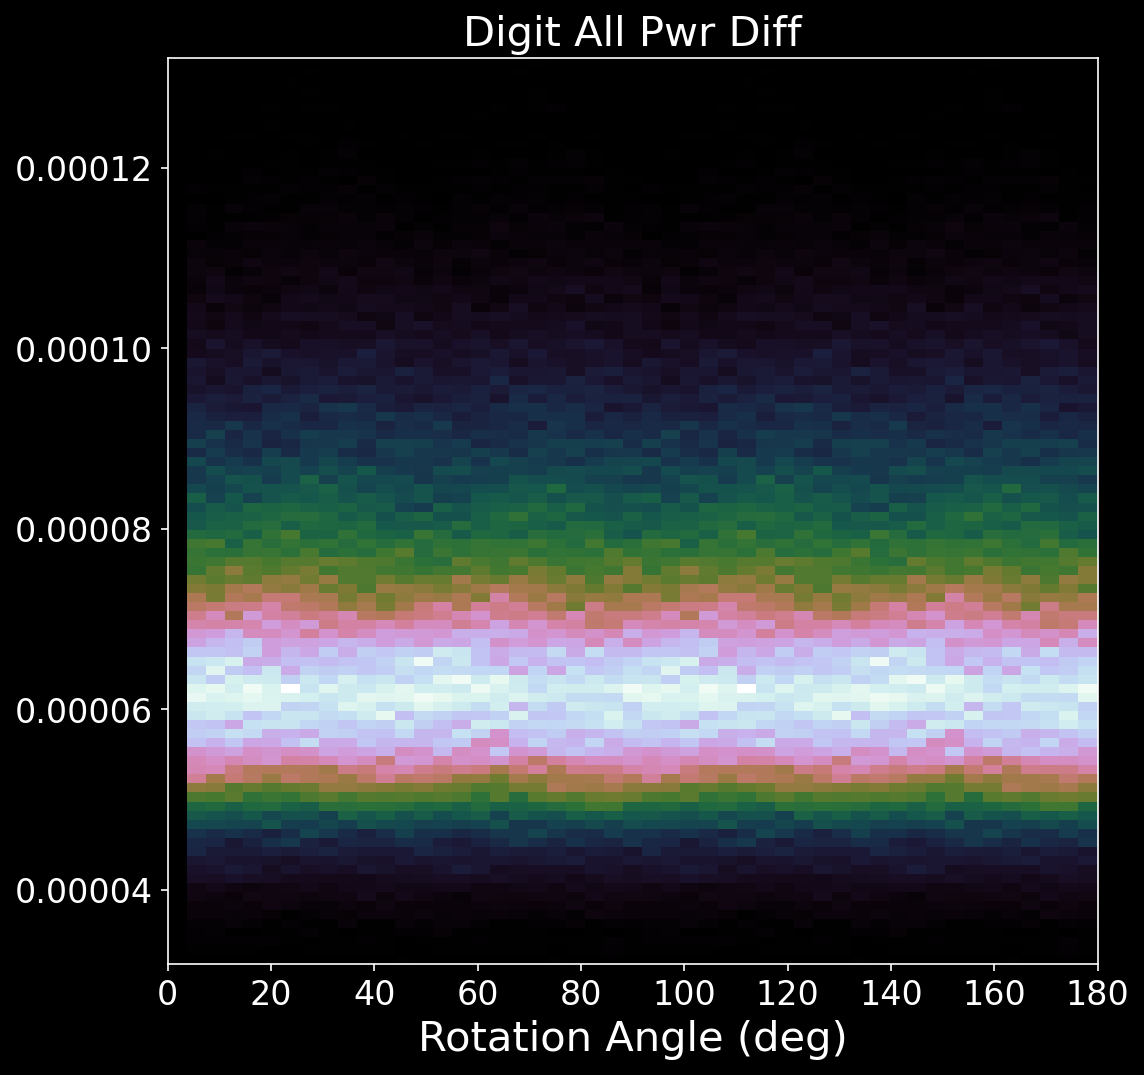

In [98]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
#plt.hist(angle_test_class,equiv_std[:,1],s=1)

ax.hist2d((angle_test*180/np.pi).T, equiv_std[:,1].T,
          bins=[48,100],cmap='cubehelix')

plt.title('Digit All Pwr Diff')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

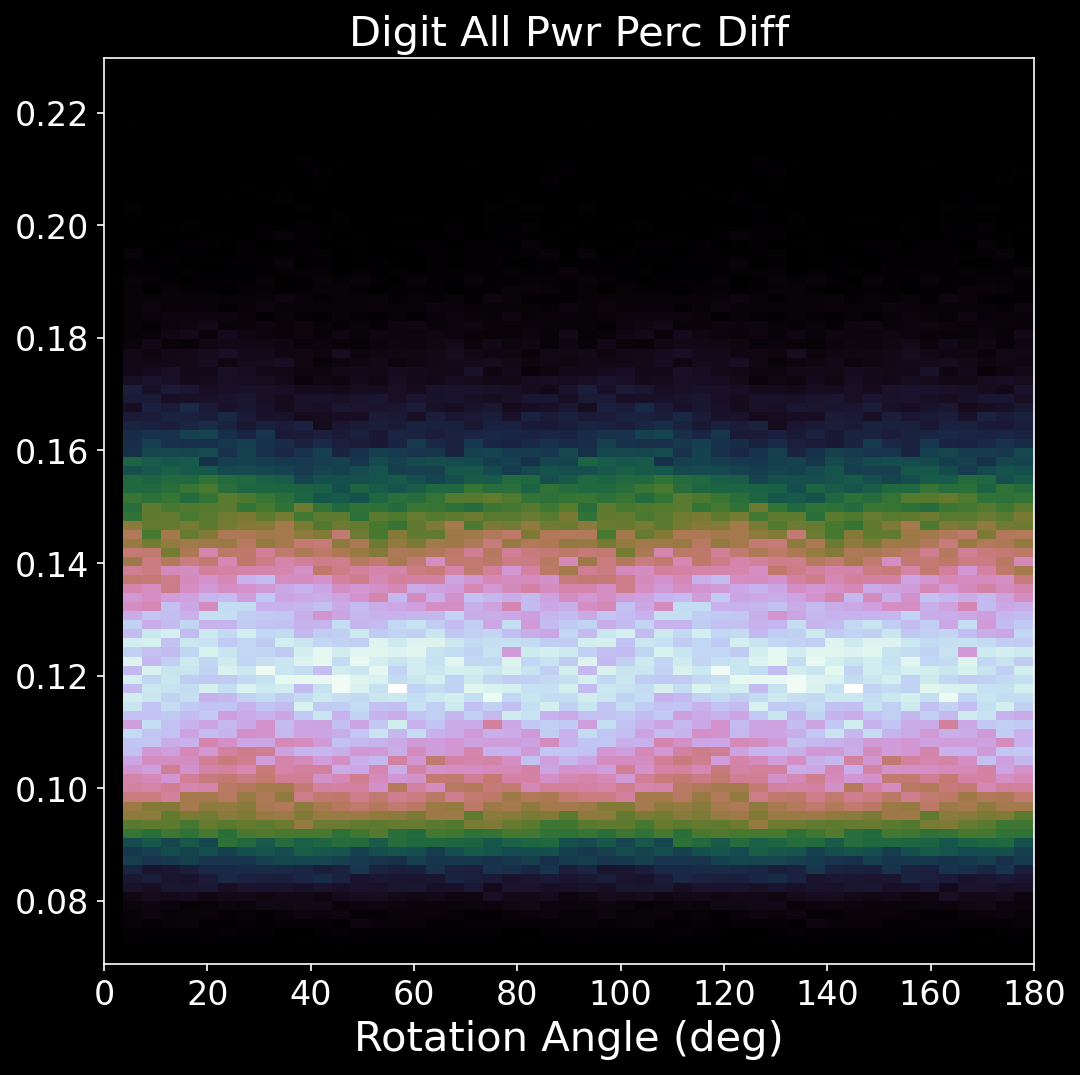

In [97]:
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
#plt.hist(angle_test_class,equiv_std[:,1],s=1)

ax.hist2d((angle_test*180/np.pi).T, equiv_std[:,0].T,
          bins=[48,100],cmap='cubehelix')

plt.title('Digit All Pwr Perc Diff')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

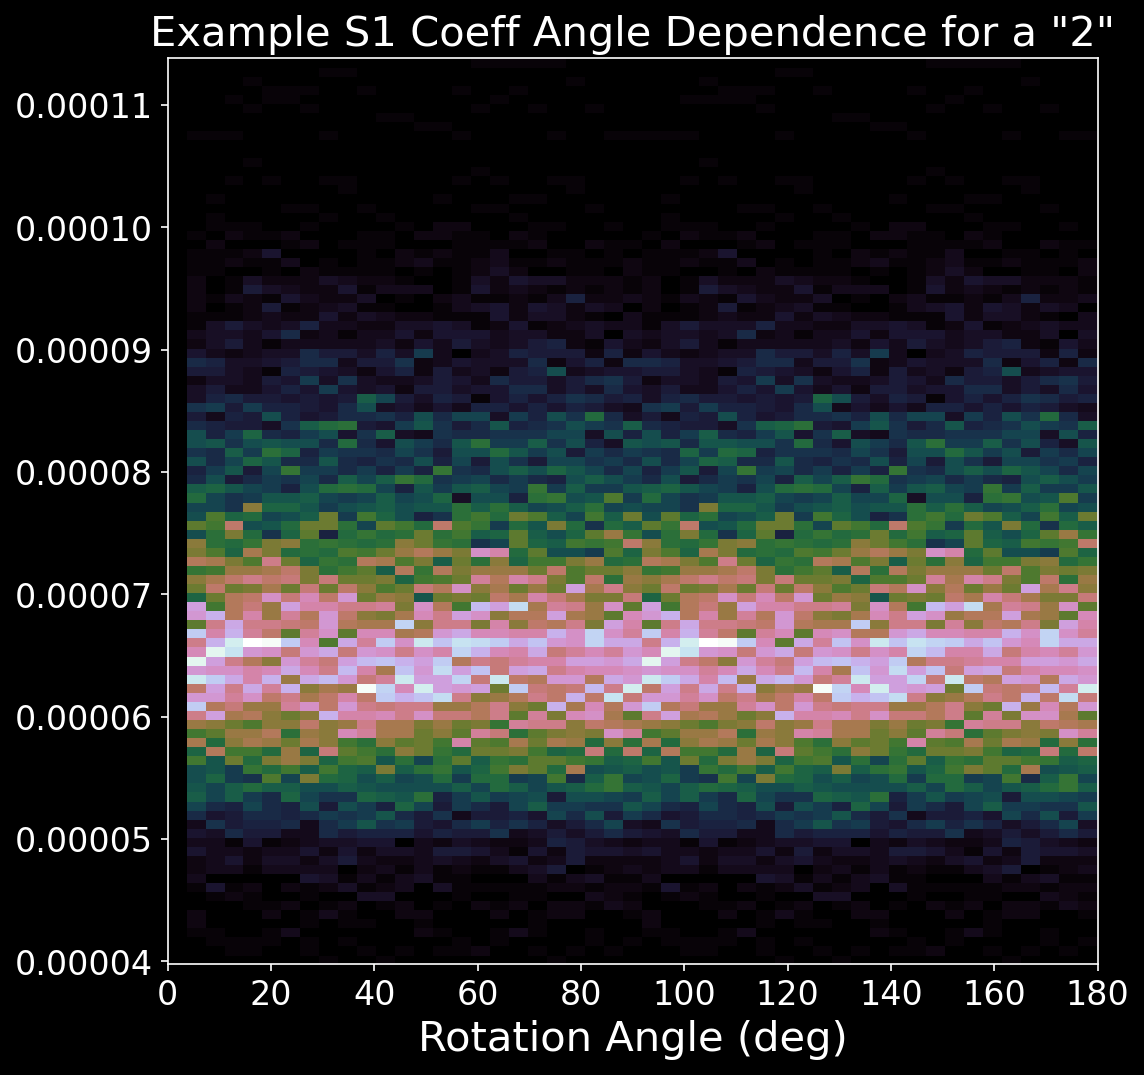

In [65]:
tst_slice = np.isin(angle_test_class,2)
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
#plt.hist(angle_test_class,equiv_std[:,1],s=1)

ax.hist2d((angle_test[tst_slice]*180/np.pi).T, equiv_std[tst_slice,1].T,
          bins=[48,100],cmap='cubehelix')

plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

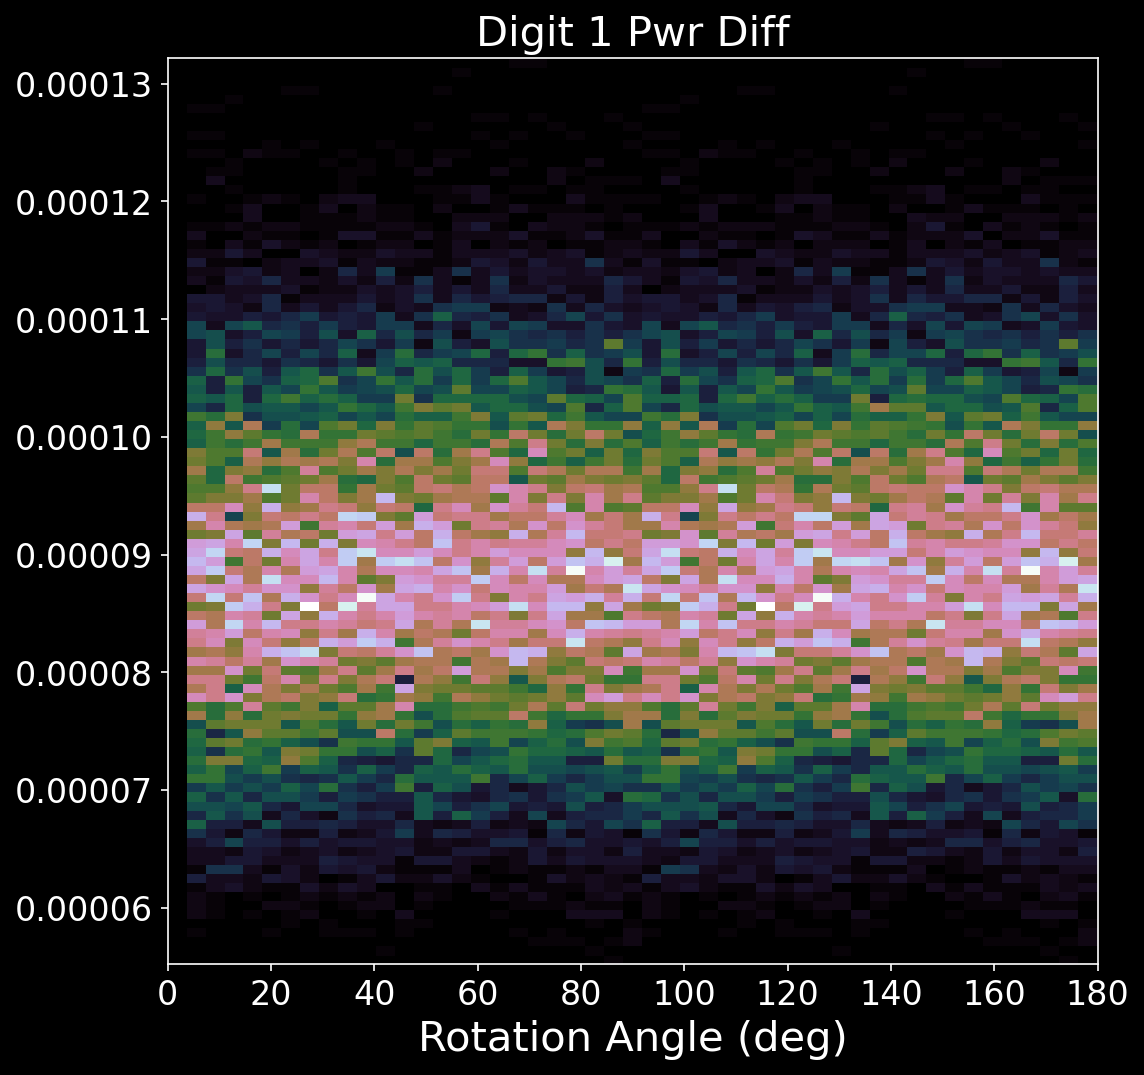

In [96]:
tst_slice = np.isin(angle_test_class,1)
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
#plt.hist(angle_test_class,equiv_std[:,1],s=1)

ax.hist2d((angle_test[tst_slice]*180/np.pi).T, equiv_std[tst_slice,1].T,
          bins=[48,100],cmap='cubehelix')

plt.title('Digit 1 Pwr Diff')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

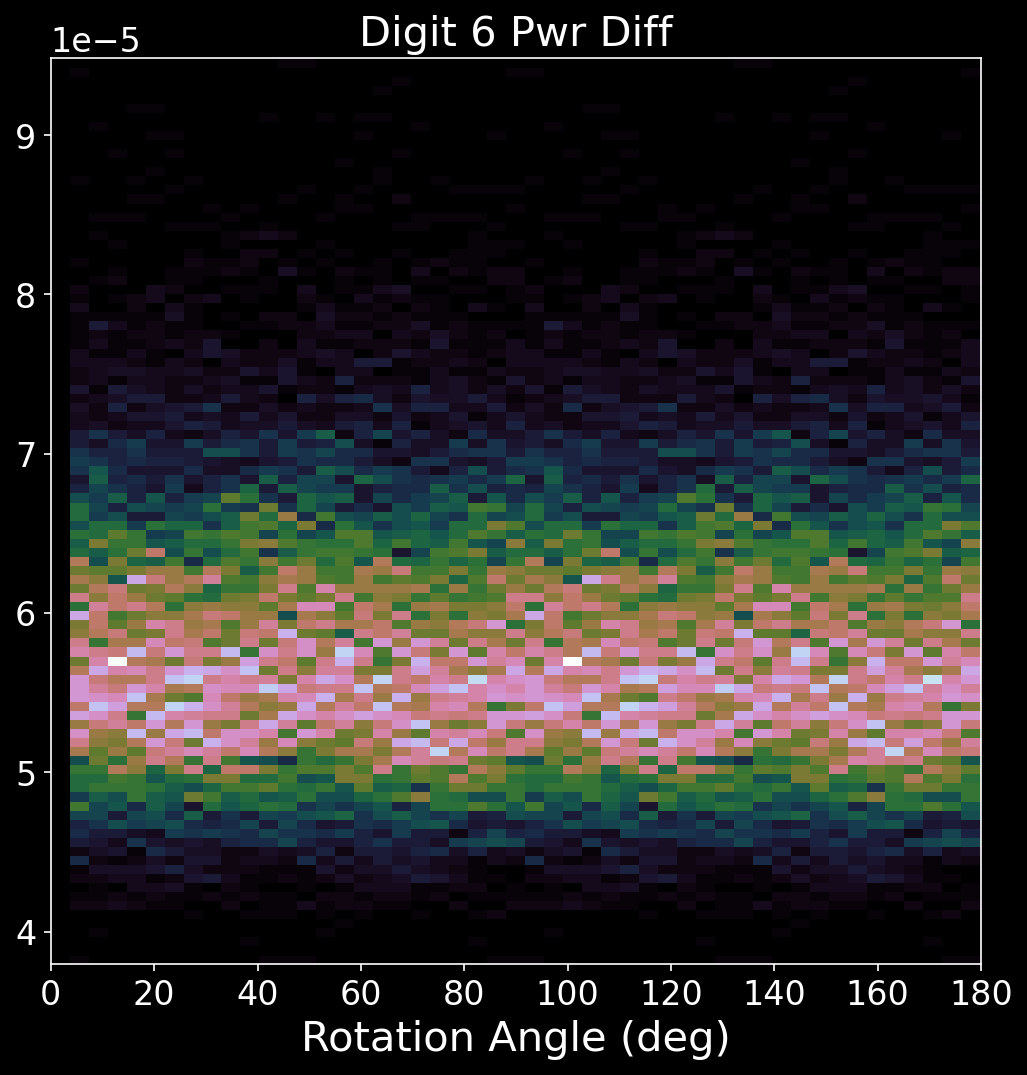

In [94]:
tst_slice = np.isin(angle_test_class,6)
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
#plt.hist(angle_test_class,equiv_std[:,1],s=1)

ax.hist2d((angle_test[tst_slice]*180/np.pi).T, equiv_std[tst_slice,1].T,
          bins=[48,100],cmap='cubehelix')

plt.title('Digit 6 Pwr Diff')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

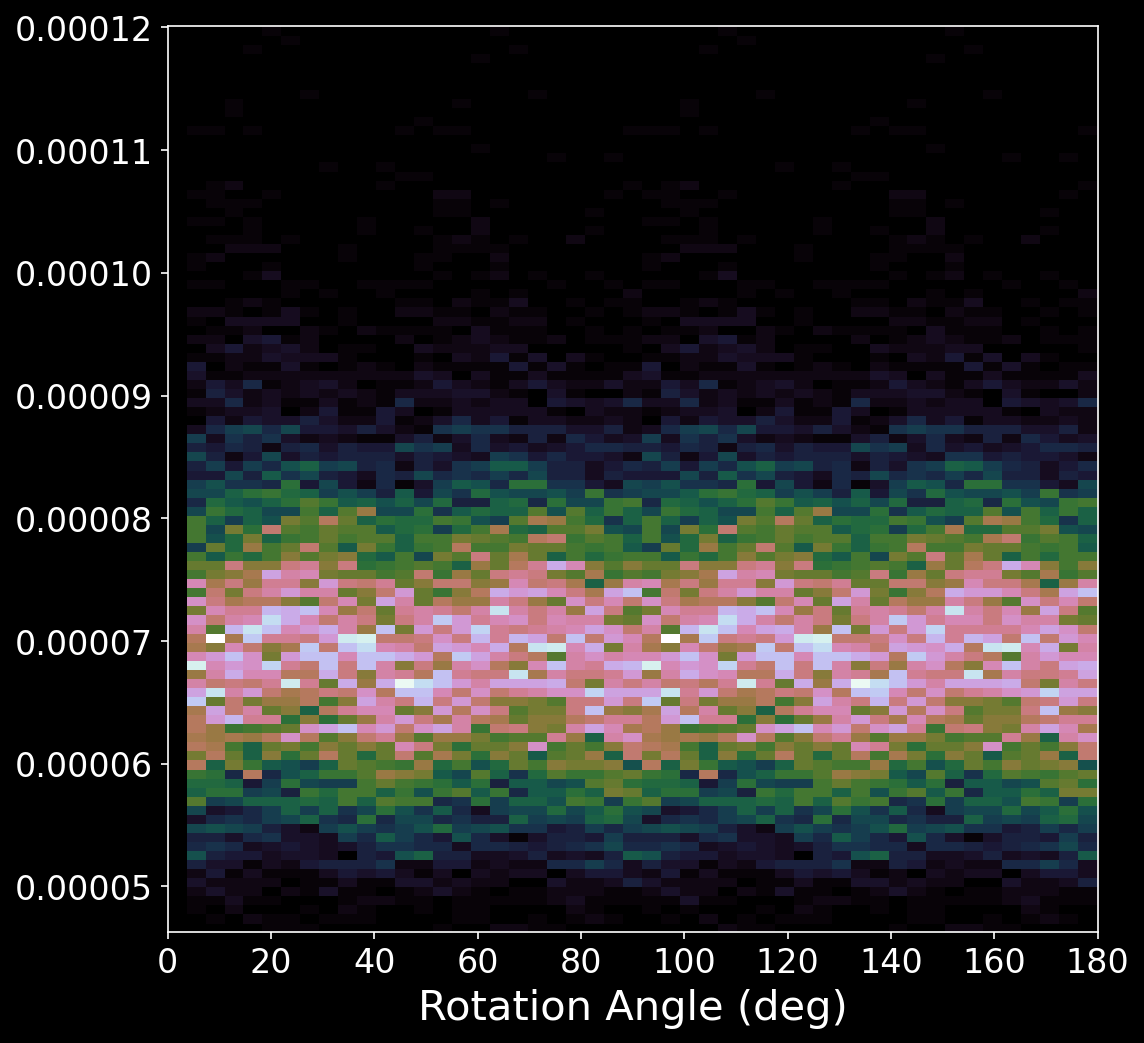

In [69]:
tst_slice = np.isin(angle_test_class,5)
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
#plt.hist(angle_test_class,equiv_std[:,1],s=1)

ax.hist2d((angle_test[tst_slice]*180/np.pi).T, equiv_std[tst_slice,1].T,
          bins=[48,100],cmap='cubehelix')

#plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

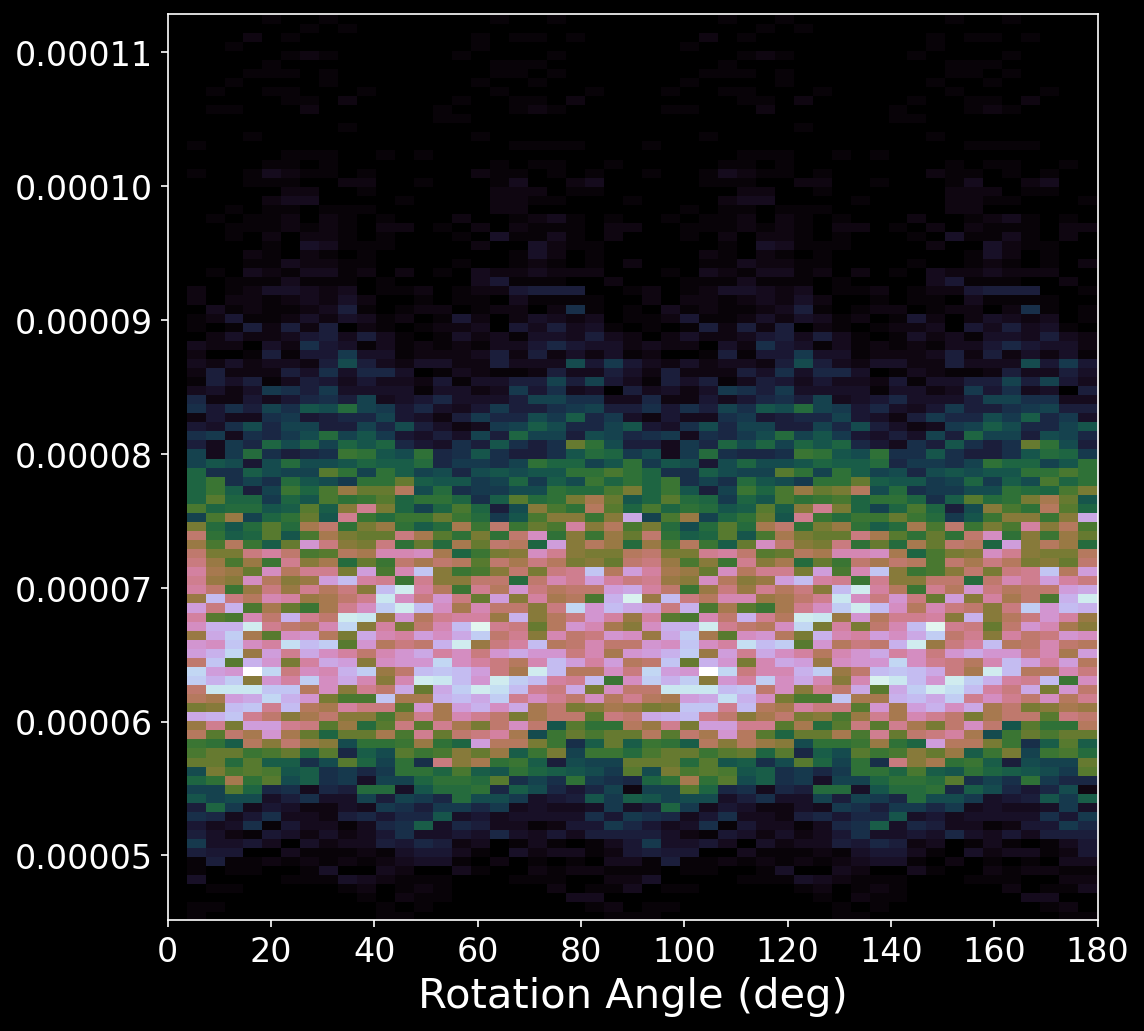

In [70]:
tst_slice = np.isin(angle_test_class,4)
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
#plt.hist(angle_test_class,equiv_std[:,1],s=1)

ax.hist2d((angle_test[tst_slice]*180/np.pi).T, equiv_std[tst_slice,1].T,
          bins=[48,100],cmap='cubehelix')

#plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()

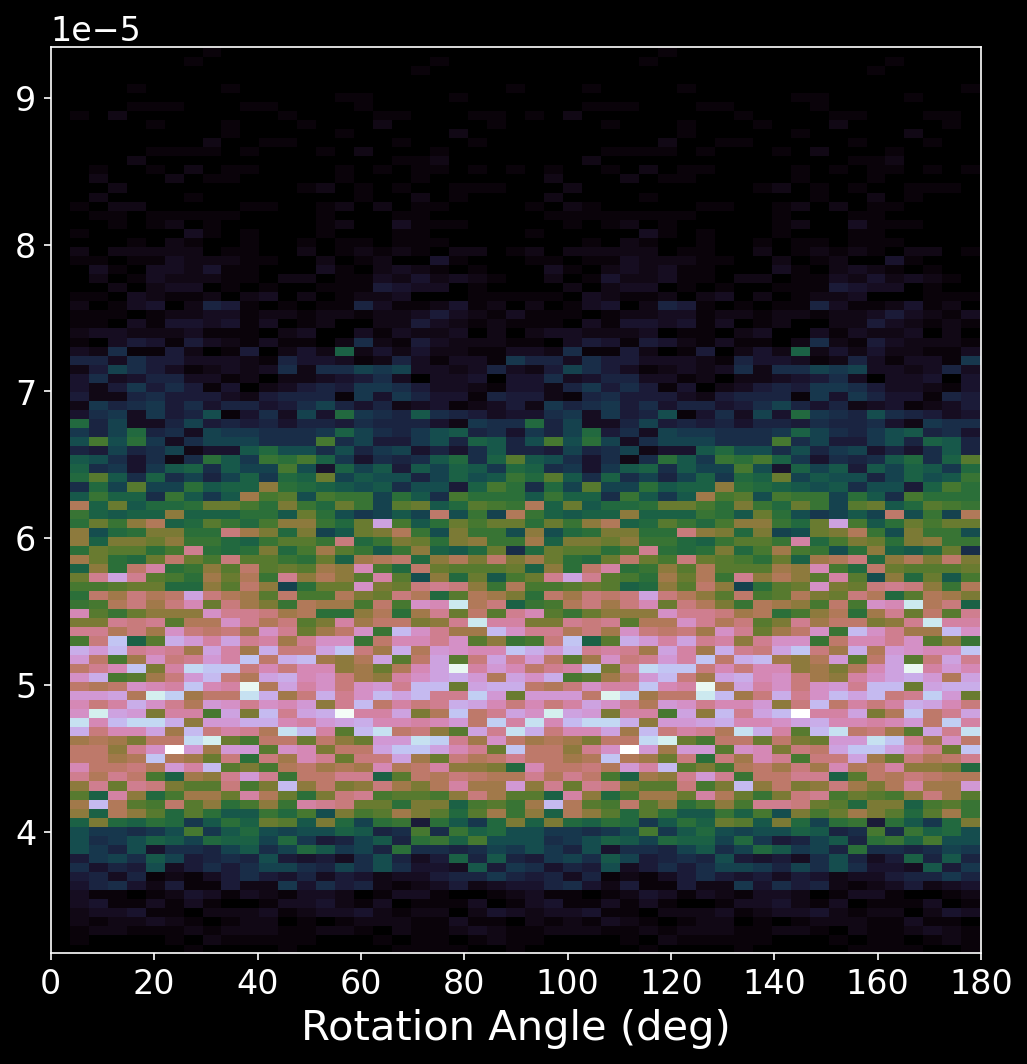

In [71]:
tst_slice = np.isin(angle_test_class,0)
fig = plt.figure(figsize=(8,8),dpi=150)
ax = fig.add_subplot(111)
#plt.hist(angle_test_class,equiv_std[:,1],s=1)

ax.hist2d((angle_test[tst_slice]*180/np.pi).T, equiv_std[tst_slice,1].T,
          bins=[48,100],cmap='cubehelix')

#plt.title('Example S1 Coeff Angle Dependence for a "2"')
plt.xlabel('Rotation Angle (deg)')
plt.xlim([0,180])

plt.show()